# DATA201 Group Project  
## Authors:  
  Grey Harris  97774899  
  Reed Earl   73244439  
  Cameron Bodger 78993602    
  Duncan Fryer   85947583  

In [ ]:
# Installing package from GitHub 
devtools::install_github("dmi3kno/polite")

In [ ]:
# Installing packages
install.packages("magrittr")
install.packages("glue")
install.packages("rvest")
install.packages("tidyverse")
install.packages("stringi")
install.packages("httr")
install.packages("jsonlite")
install.packages("lubridate")
install.packages("textclean")
install.packages("fuzzyjoin")

In [1]:
# Importing all packages used in the project

library(magrittr) # Better handling of pipes
library(glue) # To paste strings
library(rvest) # rvest makes scraping easier
library(polite) # polite is the "polite" version of rvest

# We use purrr, dplyr, stringr and tidyr from tidyverse mainly
library(tidyverse) # To work with lists and map functions, to handle strings etc
library(stringi) # For processing strings

# For API
library(httr)
library(jsonlite)

library(lubridate) # For Dates
library(textclean) # For cleaning and processing text
library(fuzzyjoin) # For joining tables together

Loading required package: xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()       masks glue::collapse()
✖ tidyr::extract()        masks magrittr::extract()
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
✖ purrr::pluck()          masks rvest::pluck()
✖ purrr::set_names()      masks magrittr::set_names()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date




Code for loading the Bitcoin page:

In [2]:
# URL for Bitcoin data between 01/01/2018 to 31/12/2018 (full year of 2018) 
bitcoin_url <- "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180101&end=20181231#"
# Read the html for bitcoin
bitcoin_page <- read_html(bitcoin_url)
bitcoin_page # Print the page for debugging

{html_document}
<html lang="en">
[1] <head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8 ...
[2] <body>\n\n<noscript><iframe src="//www.googletagmanager.com/ns.html?id=GT ...

Code for pulling the raw data from the table:

The code sourced from "Rajat Khandelwal" on youtube "https://www.youtube.com/watch?v=dP4_1ETMA5w".
The html was explored in firefox's developer mode in selector to mouse over what we wanted to find the html tags needed to extract it find correct tagging. 
We did not make calls on each one as it was easy to just get straight to what was needed.

In [3]:
# Create a dataframe from the bitcoin page from the previous code block
bitcoin_df <- bitcoin_page %>% 
    html_nodes("#historical-data > div > div.table-responsive > table") %>%
        .[[1]] %>%   # Gets inside to dataframe
            html_table(fill = TRUE) %>% 
                .[]

# Convert the dates to date objects
bitcoin_df <- bitcoin_df %>% 
    mutate(Date = as.Date(Date, "%B %d, %Y")) 

# Check the dataframe for debugging
bitcoin_df %>% 
    head()

Date,Open*,High,Low,Close**,Volume,Market Cap
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2018-12-31,3866.84,3868.74,3725.87,3742.70,"4,661,840,806","65,331,499,158"
2018-12-30,3822.38,3901.91,3797.22,3865.95,"4,770,578,575","67,475,512,827"
2018-12-29,3932.49,3963.76,3820.41,3820.41,"4,991,655,917","66,672,244,158"
2018-12-28,3653.13,3956.14,3642.63,3923.92,"5,631,554,348","68,471,837,969"
2018-12-27,3854.69,3874.42,3645.45,3654.83,"5,130,222,366","63,768,757,101"
2018-12-26,3819.67,3893.36,3769.86,3857.30,"5,326,547,918","67,292,819,465"


## Automation of scraping

Code for selecting the table from the page by it's elements:

In [4]:
selector <- "#historical-data > div > div.table-responsive > table" 

Function coin_scrape takes a string type, thats a name of a crypto-currency in the top 100 rank on coinmarketcap.com  

In [5]:
# Arbitrary number of top crypto curriences is decided here, maximum is 100, we are using 5.
# The site doesn't like it when I try grabbing everything at once.
number_of_crytocurrencies <- 5

In [6]:
coin_scrape <- function(cryto_coin) {
  # Function that takes a string that represents a cryptocurrencies name in the top 100 coins on coinmarketcap.com and returns a dataframe containing the
  # Name of the currency, Date of entry, High, Low, Close, Volume and Market Cap
  crypto_coin <- paste(cryto_coin) # Makes sure I'm not sending through a list.
  url <- glue("https://coinmarketcap.com/currencies/{cryto_coin}/historical-data/?start=20180101&end=20181231#")
    read_html(url) %>% 
        html_nodes(selector) %>%
            .[[1]] %>%   # Gets inside to dataframe
                html_table() %>% 
                    mutate(Date = as.Date(Date, "%B %d, %Y")) %>%
                        mutate(Crytocurrencies = paste(str_to_upper(cryto_coin))) %>%
                            select(Crytocurrencies, everything()) # Putting type of Crytocurrency at start of dataframe
}

So this cell is just getting the names of the crytocurrency that are on coinmarketcap.com  
Specifically the Top 100 Cryptocurrencies by Market Capitalization.  
Getting the top X (in this case X is 5 as was decided earlier) ranked crytocurrency off coinmarket.  
**ATTN MARKER**: If this is re-run during marking and does not work it is possible that different coins are not at the top 5 and some times the sites URLs are incorrect/outdated and do not match the coins current name this can cause the automation to not work its their site being badly designed, not our code.  
It's pretty unlikely to be a problem, I've gone through the top 70 and they all worked fine.

In [7]:
url_ranked <- "https://coinmarketcap.com" # this is the base url from where the scraping starts
rank_page <- read_html(url_ranked) # reads it
# so idea is to grab the hyperlinks to the top 5 cryto currencies to pass them to purr
rank_page <- rank_page %>% html_nodes(".currency-name-container") %>%
  html_text()
i = 1
alist = list()
j = 1
while (i <= number_of_crytocurrencies) {
  if (rank_page[i] == "XRP") {  # xrp is the only one that doesn't have same url address as it's name
    rank_page[i] = "ripple"     # I checked the rest, and they were fine so i'll just catch this here.
  }
  alist[j] = paste(rank_page[i])
  #tidy up the names of crytocurrencies, spaces need to be - and all lower case so i can put them in url.
  alist[j] <- str_replace_all(alist[j], " ", "-")
  alist[j] <- str_to_lower(alist[j])
 #XRP is the only one that doesn't work as name doesnt match address name.
  i = i + 1
  j = j + 1
}
alist

[[1]]
[1] "bitcoin"

[[2]]
[1] "ethereum"

[[3]]
[1] "ripple"

[[4]]
[1] "tether"

[[5]]
[1] "bitcoin-cash"

In [8]:
# Checking that the function works for debugging
example <- coin_scrape(alist[1])  
example %>% 
    head()

Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BITCOIN,2018-12-31,3866.84,3868.74,3725.87,3742.70,"4,661,840,806","65,331,499,158"
BITCOIN,2018-12-30,3822.38,3901.91,3797.22,3865.95,"4,770,578,575","67,475,512,827"
BITCOIN,2018-12-29,3932.49,3963.76,3820.41,3820.41,"4,991,655,917","66,672,244,158"
BITCOIN,2018-12-28,3653.13,3956.14,3642.63,3923.92,"5,631,554,348","68,471,837,969"
BITCOIN,2018-12-27,3854.69,3874.42,3645.45,3654.83,"5,130,222,366","63,768,757,101"
BITCOIN,2018-12-26,3819.67,3893.36,3769.86,3857.30,"5,326,547,918","67,292,819,465"


In [9]:
# Creating a tibble of the top X coin types and checking it for debugging
currencies <- tibble(coin_type = paste(alist)) %>% tidyr::unnest()
currencies

Warning message:
“`cols` is now required.
Please use `cols = c()`”


coin_type
<chr>
bitcoin
ethereum
ripple
tether
bitcoin-cash


In [10]:
# This is a dataframe of dataframes, doesn't look nice in jupyter but looks good in Rstudio.
table_data  <- currencies %>%
      mutate(data = purrr::map(coin_type, ~coin_scrape(.x)))

In [11]:
table_data %>% 
    glimpse()

Observations: 5
Variables: 2
$ coin_type <chr> "bitcoin", "ethereum", "ripple", "tether", "bitcoin-cash"
$ data      <list> [<data.frame[365 x 8]>, <data.frame[365 x 8]>, <data.frame…


In [12]:
# Unnesting table_data allows us to just have the one dataframe to graph.
graph_df <- table_data %>% 
    unnest()
graph_df %>% 
    head()

Warning message:
“`cols` is now required.
Please use `cols = c(data)`”


coin_type,Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bitcoin,BITCOIN,2018-12-31,3866.84,3868.74,3725.87,3742.70,"4,661,840,806","65,331,499,158"
bitcoin,BITCOIN,2018-12-30,3822.38,3901.91,3797.22,3865.95,"4,770,578,575","67,475,512,827"
bitcoin,BITCOIN,2018-12-29,3932.49,3963.76,3820.41,3820.41,"4,991,655,917","66,672,244,158"
bitcoin,BITCOIN,2018-12-28,3653.13,3956.14,3642.63,3923.92,"5,631,554,348","68,471,837,969"
bitcoin,BITCOIN,2018-12-27,3854.69,3874.42,3645.45,3654.83,"5,130,222,366","63,768,757,101"
bitcoin,BITCOIN,2018-12-26,3819.67,3893.36,3769.86,3857.30,"5,326,547,918","67,292,819,465"


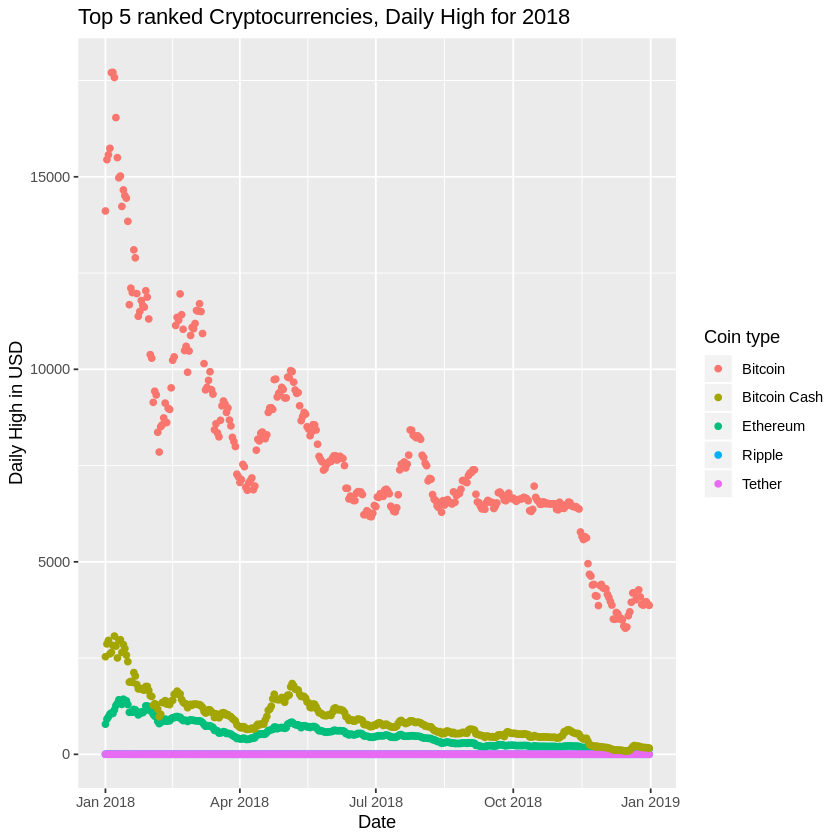

In [13]:
# Create a scatter point graph from the dataframe with dataframes of all the top X cryptocurrency data to compare their value over time
coin_top_5_plot <- ggplot(aes(x = Date, y = High, color = coin_type), data = graph_df) +
  geom_point() + 
  ggtitle("Top 5 ranked Cryptocurrencies, Daily High for 2018") + # Setting the title
  ylab("Daily High in USD") + # Changing the y labels
  scale_color_hue(name = "Coin type", labels = c("Bitcoin", "Bitcoin Cash", "Ethereum", "Ripple", "Tether")) # Changing the legend labels
    
coin_top_5_plot

Originally, we planned to use the API from the same site we scraped to pull the historical data and see if the data
in their api matched the data we scraped from their tables, however we found out to get that data we had to pay
for extra access to it as it was not included in their free basic developer package, we were also limited to a small
number of requests per day. The code we used is below to demonstrate what we tried and learnt doing it like passing 
authentication keys through as headers in httr to be able to access anything at all.  
  
Further below we went to a large crypo exchange and used their api to pull data to graph instead.  
  
The code for running the calls to api's was made using the httr manual online and the help/information pages for each sites API help pages, and reverse engineered from their examples.

In [14]:
# Loading inputs for api url and keys as easily reusable variables
api_address <- "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest?start=1&limit=5000&convert=USD"
url_historical <- "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/historical?start=1&limit=5000&convert=USD"
api_address[1]

api_developer_key <- "117569cc-658b-4b88-8c92-f5e7fa045cd7"

marketcap_json_file <- GET(api_address, add_headers("X-CMC_PRO_API_KEY" = api_developer_key))
marketcap_json_file

[1] "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest?start=1&limit=5000&convert=USD"

Response [https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest?start=1&limit=5000&convert=USD]
  Date: 2019-10-22 23:12
  Status: 200
  Content-Type: application/json; charset=utf-8
  Size: 2.62 MB
{
    "status": {
        "timestamp": "2019-10-22T23:12:40.254Z",
        "error_code": 0,
        "error_message": null,
        "elapsed": 239,
        "credit_count": 13,
        "notice": null
    },
    "data": [
...

Checked the class of the returned data as jsonlite requires certan data types to be able to convert them into a data frame for you.  
The contents is left commented out as its massive and will freeze your notebook for a couple mins so check at your own peril....

In [15]:
class(marketcap_json_file)
#content(marketcap_json_file) # Commented out as it's too big to be displayed for debugging all the time

[1] "response"

The data type was not what we wanted as it was a response object so we converted it to text so it could be feed into the fromJSON function.  
This function returns the contents as a dataframe, the data was not very useful as it just contains the top 100 coin types and their marketcap but no values so we changed our request to get historical data instead below.

In [16]:
text_json <- content(marketcap_json_file, as = 'text')
marketcap_data <- fromJSON(text_json)
#marketcap_data # Commented out as its just a huge number of coins that are tracked on the site

This is where we realised the API was not going to be much use to us as you have to pay for anything useful in it.  
see -> "error_message": "Your API Key subscription plan doesn't support this...  
However, it was still a good learning experience so we kept the code in here then moved to another exchange to use their API instead.

In [17]:
# Getting the historical data from coinmarketcap 
historical_data <- GET(url_historical, add_headers("X-CMC_PRO_API_KEY" = api_developer_key))
historical_data # Printing it for debugging

Response [https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/historical?start=1&limit=5000&convert=USD]
  Date: 2019-10-22 23:12
  Status: 403
  Content-Type: application/json; charset=utf-8
  Size: 240 B
{
    "status": {
        "timestamp": "2019-10-22T23:12:42.654Z",
        "error_code": 1006,
        "error_message": "Your API Key subscription plan doesn't support this...
        "elapsed": 0,
        "credit_count": 0
    }

Using the REST api with the BitMEX exchange to sample some trading data from their order books.  
Source for the code is all from BitMEX's API help page and trial and error on our part.  
https://www.bitmex.com/app/apiOverview

In [18]:
# API lets us put conditions onto our request so with this URL we are requesting all the trading data from the first day of 2018 with a limit of 20 entries so there might be some data cut out in this case.
bitmex_url <- "https://www.bitmex.com/api/v1/trade?count=200&reverse=false&startTime=1%2F01%2F18&endTime=1%2F02%2F18"
fromJSON(content(GET(bitmex_url), as = "text"))

timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>
2018-01-01T00:00:00.000Z,.BCHXBT,Buy,0,1.710000e-01,MinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.BVOL24H,Buy,0,7.430000e+00,MinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.BVOL7D,Buy,0,2.066000e+01,ZeroMinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.BXBT,Buy,0,1.387157e+04,MinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.BXBTJPY,Buy,0,1.773154e+06,MinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.DASHXBT,Buy,0,7.355920e-02,PlusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.ETCXBT,Buy,0,1.884000e-03,ZeroMinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.ETHBON,Buy,0,1.860000e-04,ZeroMinusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA
2018-01-01T00:00:00.000Z,.ETHBON2H,Buy,0,1.860000e-04,PlusTick,00000000-0000-0000-0000-000000000000,NA,NA,NA


In [19]:
# Calls to bitmex api for historical settlement data

# This url is asking for the daily trade data for the bitcoin futures from the start of 2017 to the start of 2019, this has a limit of 750 entries which is the maximum you can get from the API, as there is only ~730 days in this span
# We shouldn't have to worry about any lost data
bitmex_settelment_url2 <- "https://www.bitmex.com/api/v1/trade/bucketed?binSize=1d&partial=false&symbol=XBTUSD&count=750&reverse=false&startTime=01-01-2017&endTime=01-01-2019"
api_data2 <- fromJSON(content(GET(bitmex_settelment_url2), as = "text"))
# Displays data for debugging
api_data2

timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2017-01-01T00:00:00.000Z,XBTUSD,957.57,968.39,940.00,968.29,3334,12869720,955.4840,5673,1.346934e+12,13469.345,12869720
2017-01-02T00:00:00.000Z,XBTUSD,968.29,1009.87,960.90,1001.15,6104,20292354,989.8932,2998,2.049957e+12,20499.574,20292354
2017-01-03T00:00:00.000Z,XBTUSD,1001.15,1035.00,996.54,1022.76,9717,37013221,1016.9112,13997,3.639787e+12,36397.874,37013221
2017-01-04T00:00:00.000Z,XBTUSD,1022.76,1040.66,1003.00,1036.90,5708,21522604,1025.6095,5562,2.098536e+12,20985.357,21522604
2017-01-05T00:00:00.000Z,XBTUSD,1036.90,1177.90,1036.49,1152.00,15978,59945268,1105.1067,20000,5.424428e+12,54244.275,59945268
2017-01-06T00:00:00.000Z,XBTUSD,1152.00,1180.45,876.08,1005.33,22150,93256039,1019.3472,20000,9.148668e+12,91486.681,93256039
2017-01-07T00:00:00.000Z,XBTUSD,1005.33,1029.24,841.75,895.85,15400,54631519,919.7094,10721,5.940129e+12,59401.290,54631519
2017-01-08T00:00:00.000Z,XBTUSD,895.85,912.72,805.03,908.22,13892,34472340,861.4748,1800,4.001556e+12,40015.565,34472340
2017-01-09T00:00:00.000Z,XBTUSD,908.22,939.33,877.58,909.25,11676,25132654,911.9594,4000,2.755910e+12,27559.102,25132654


In [20]:
api_data1 <- api_data2[1:6]   # We're not interested in every column
api_data1 <- api_data1 %>% 
    mutate(daily_average = (high + low)/ 2)  # New variable. Not a true average but good enough for our use case.
api_data1 <- api_data1 %>% 
  mutate(date = as.Date(timestamp, "%Y-%m-%d")) # Convert to date to Date type in year-month-day format

# Display data for debugging
api_data1

timestamp,symbol,open,high,low,close,daily_average,date
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
2017-01-01T00:00:00.000Z,XBTUSD,957.57,968.39,940.00,968.29,954.195,2017-01-01
2017-01-02T00:00:00.000Z,XBTUSD,968.29,1009.87,960.90,1001.15,985.385,2017-01-02
2017-01-03T00:00:00.000Z,XBTUSD,1001.15,1035.00,996.54,1022.76,1015.770,2017-01-03
2017-01-04T00:00:00.000Z,XBTUSD,1022.76,1040.66,1003.00,1036.90,1021.830,2017-01-04
2017-01-05T00:00:00.000Z,XBTUSD,1036.90,1177.90,1036.49,1152.00,1107.195,2017-01-05
2017-01-06T00:00:00.000Z,XBTUSD,1152.00,1180.45,876.08,1005.33,1028.265,2017-01-06
2017-01-07T00:00:00.000Z,XBTUSD,1005.33,1029.24,841.75,895.85,935.495,2017-01-07
2017-01-08T00:00:00.000Z,XBTUSD,895.85,912.72,805.03,908.22,858.875,2017-01-08
2017-01-09T00:00:00.000Z,XBTUSD,908.22,939.33,877.58,909.25,908.455,2017-01-09


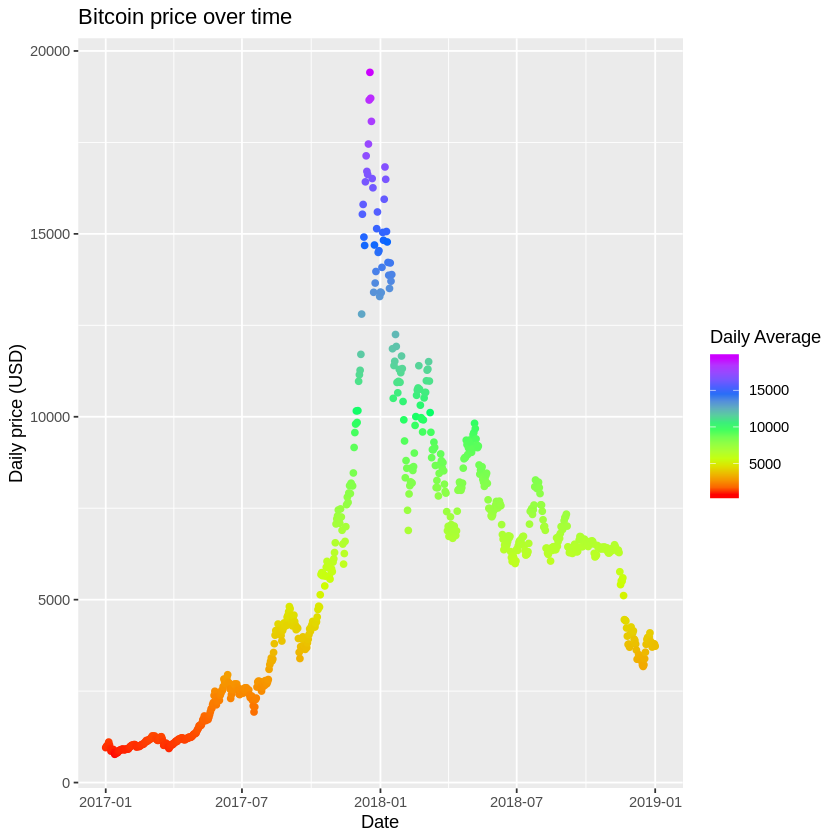

In [21]:
# We then created a heat mapped scatter plot of the extracted data over time showing the 
# closing/settlement price each day over a couple months

scatter_plot <- ggplot(api_data1, aes(x=date, y=daily_average, color=daily_average)) +
    geom_point() +
    ggtitle("Bitcoin price over time") + 
    ylab("Daily price (USD)") + 
    xlab("Date") +
    scale_color_gradientn(name = "Daily Average", colours = rainbow(5)) # Changing the legend labels and colours

scatter_plot

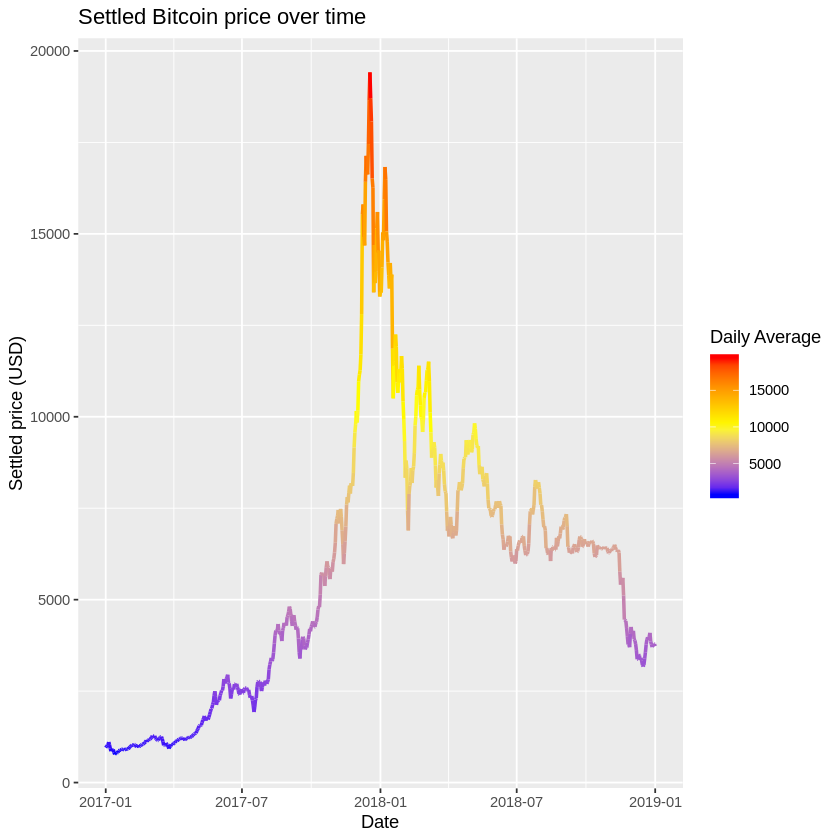

In [22]:
# We then created a heat mapped scatter plot of the extracted data over time showinig the 
# closing/settlement price each day over a couple months

scatter_plot <- ggplot(api_data1, aes(x=date, y=daily_average, color=daily_average)) + 
    geom_line(size = 1) +
    ggtitle("Settled Bitcoin price over time") + 
    ylab("Settled price (USD)") + 
    xlab("Date") +
    scale_color_gradientn(name = "Daily Average", colours = c("blue", "yellow", "red")) # Changing the legend labels and colours

scatter_plot

Now we shift our attention to gpu prices. 
Unfortunately historical price data proved hard to find to scrape or pull from an api. 
This techspot data is far from ideal as their are few data points. However since it's so messy, it was a good way to show quite a few of the data wrangling methods we've learned in this course.  
Further below we acquire more gpu price data that somebody else scraped into a csv.

Some of the gpu names come out horrible (e.g "GeForce\r\n\t\t\tGTX 1050 Ti"), can use replace_non_ascii from the textclean package to fix them easily  
Source: https://cran.r-project.org/web/packages/textclean/textclean.pdf

In [23]:
url_july <- "https://www.techspot.com/article/1662-graphics-card-pricing-q3-2018/"
url_oct <- "https://www.techspot.com/article/1729-graphics-card-pricing-q4-2018/"
url_list <- c(url_july, url_oct)

The function gpu_scraper grabs the table from the url

In [24]:
gpu_scraper <- function(url){
    # Function that takes a url, scrapes it and returns a dataframe containing GPU price data
    table <- read_html(url) %>%  # Reads the html
        html_nodes("table") %>%  # Selects the table nodes
            html_table(header = TRUE, trim = TRUE) # Turn the table into a dataframe
    
    df <- table[[1]]
    
    names(df)[1] <- "gpu" # Rename the first column to 'gpu' 
    df <- df %>% 
        mutate(gpu = replace_non_ascii(gpu)) # Removing non ascii characters to tidy the horrible GPU names
    
    return(df)
}

In [25]:
july_df <- gpu_scraper(url_july)
july_df

gpu,MSRP,April 2017,November 2017,January 2018,Current Typical (July 2018),Current Best (July 2018)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GeForce GTX 1050 Ti,$140,$150,$160,$190,$190,$170
GeForce GTX 1060 3GB,$200,$220,$235,$410,$260,$230
GeForce GTX 1060 6GB,$250,$280,$310,$530,$300,$260
GeForce GTX 1070,$380,$420,$470,$890,$440,$400
GeForce GTX 1070 Ti,$450,,$500,$900,$480,$450
GeForce GTX 1080,$500,$560,$590,$940,$530,$500
GeForce GTX 1080 Ti,$700,$755,$740,"$1,200",$750,$720
Radeon RX 550,$80,$80,$100,$120,$130,$115
Radeon RX 560 16CU,$100,,$130,$140,$160,$150


In [26]:
oct_df <- gpu_scraper(url_oct)
oct_df

gpu,MSRP,May-18,Jul-18,Oct-18
<chr>,<chr>,<chr>,<chr>,<chr>
GeForce GTX 1050 Ti,$ 140,$ 190,$ 170,$ 170
GeForce GTX 1060 3GB,$ 200,$ 230,$ 230,$ 220
GeForce GTX 1060 6GB,$ 250,$ 300,$ 290,$ 250
GeForce GTX 1070,$ 380,$ 470,$ 400,$ 380
GeForce GTX 1070 Ti,$ 450,$ 500,$ 450,$ 390
GeForce GTX 1080,$ 500,$ 550,$ 500,$ 450
GeForce GTX 1080 Ti,$ 700,$ 900,$ 720,$ 700
GeForce RTX 2070,$ 500,N/A,N/A,$ 600
GeForce RTX 2080,$ 700,N/A,N/A,$ 790


Neither table is tidy. We wanted to use map_df on the url_list vector but they were just too different from each other and required separate processing.  
We will need to gather the dates into a column.  
The july_df dates are uglier than they look, eg "April 2017" is actually "April\r\n\t\t\t2017" so they'll need to be changed if we want to convert them to date objects.  
The prices aren't numeric, and we need to deal with the leading dollar sign.  
We have na values to deal with, which arise from the newer RTX gpu's that weren't released during the crypto bubble anyway.  
We would like to create two new columns, "price_difference" is the difference between the recommended retail price and the price it was actually being sold for, and "brand" is the manufacturer.  
We can start by defining a function that deals with the bulk of these issues. 

In [27]:
convert_values <- function(df) {
    # Function that converts the the price strings to numbers since they're in $ and then determines the price differences
    # Then determines which brand the GPU is and returns the new dataframe
    
    # Converts the date strings to date objects
    df$date = parse_date_time(df$date, c("my"))

    # Convert the prices to numeric
    df <- df %>% mutate(price = parse_number(price, na = c("", "NA", "$", "N/A")),
                        MSRP = parse_number(MSRP, na = c("", "NA", "$", "N/A")),
                        # Calculate the difference in price between recommended price and actual price
                        `price difference` = price - MSRP,
                        brand = ifelse(grepl("Radeon", gpu), "AMD", "Nvidia")) 
    
    # Remove the rows with NA (the newer RTX gpus)
    df <- na.omit(df)
    return(df)
    }

Now we just need to rename the messy date names, drop the columns we don't want, and gather the data into a long format.  

In [28]:
july_prices <- july_df %>% 
  select(gpu, 
         MSRP, 
         `April 2017` = `April\r\n\t\t\t2017`,
         `November 2017`,
         `January 2018` = `January\r\n\t\t\t2018`) %>% 
              gather(`April 2017`,`November 2017`, `January 2018`, key = "date", value = "price")

july_prices <- convert_values(july_prices)
july_prices

,gpu,MSRP,date,price,price difference,brand
,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
1,GeForce GTX 1050 Ti,140,2017-04-01,150,10,Nvidia
2,GeForce GTX 1060 3GB,200,2017-04-01,220,20,Nvidia
3,GeForce GTX 1060 6GB,250,2017-04-01,280,30,Nvidia
4,GeForce GTX 1070,380,2017-04-01,420,40,Nvidia
6,GeForce GTX 1080,500,2017-04-01,560,60,Nvidia
7,GeForce GTX 1080 Ti,700,2017-04-01,755,55,Nvidia
8,Radeon RX 550,80,2017-04-01,80,0,AMD
10,Radeon RX 570,170,2017-04-01,190,20,AMD
11,Radeon RX 580 8GB,230,2017-04-01,260,30,AMD


In [29]:
oct_prices <- oct_df %>% 
  gather(`May-18`, `Jul-18`, `Oct-18`, key = "date", value = "price")

oct_prices <- convert_values(oct_prices)
oct_prices

,gpu,MSRP,date,price,price difference,brand
,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
1,GeForce GTX 1050 Ti,140,2018-05-01,190,50,Nvidia
2,GeForce GTX 1060 3GB,200,2018-05-01,230,30,Nvidia
3,GeForce GTX 1060 6GB,250,2018-05-01,300,50,Nvidia
4,GeForce GTX 1070,380,2018-05-01,470,90,Nvidia
5,GeForce GTX 1070 Ti,450,2018-05-01,500,50,Nvidia
6,GeForce GTX 1080,500,2018-05-01,550,50,Nvidia
7,GeForce GTX 1080 Ti,700,2018-05-01,900,200,Nvidia
11,Radeon RX 560 16CU,100,2018-05-01,140,40,AMD
12,Radeon RX 570,170,2018-05-01,260,90,AMD


Much tidier. We can combine them into one dataframe with bind_rows()

In [30]:
gpu_prices <- bind_rows(july_prices, oct_prices)
gpu_prices

gpu,MSRP,date,price,price difference,brand
<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
GeForce GTX 1050 Ti,140,2017-04-01,150,10,Nvidia
GeForce GTX 1060 3GB,200,2017-04-01,220,20,Nvidia
GeForce GTX 1060 6GB,250,2017-04-01,280,30,Nvidia
GeForce GTX 1070,380,2017-04-01,420,40,Nvidia
GeForce GTX 1080,500,2017-04-01,560,60,Nvidia
GeForce GTX 1080 Ti,700,2017-04-01,755,55,Nvidia
Radeon RX 550,80,2017-04-01,80,0,AMD
Radeon RX 570,170,2017-04-01,190,20,AMD
Radeon RX 580 8GB,230,2017-04-01,260,30,AMD


and have a plot

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



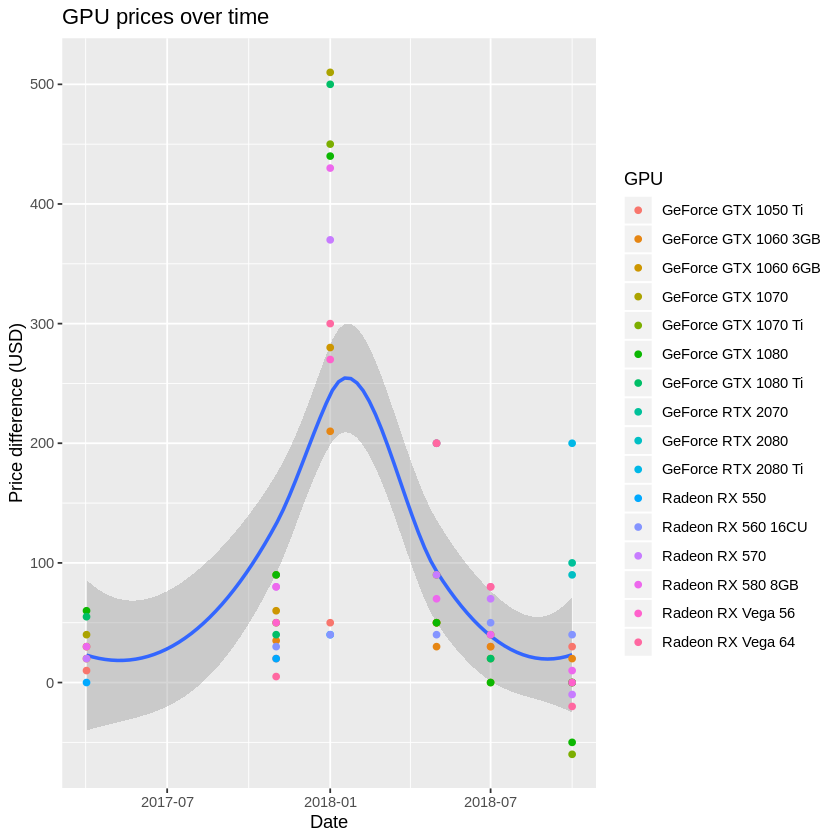

In [31]:
ggplot(data = gpu_prices, aes(x = date, y = `price difference`)) +
    labs(title = "GPU prices over time", x = "Date", y = "Price difference (USD)") + 
    geom_smooth() +
    geom_point(aes(colour = gpu)) +
    scale_color_discrete(name = "GPU") # Changing the legend title

In [32]:
#plot_grid(btc_price_plot, gpu_plot)

We came across an unofficial python api for pcpartpicker.com, but it is unmaintained and we couldn't get it to work. Fortunately, there is a dataset on kaggle.com from when it did.  

Full credit for this dataset to Kamil Raczycki from Wrocław University of Science and Technology in Wrocław, Poland.
We use his data under the Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0)  
Link to licence:  
https://creativecommons.org/licenses/by-sa/4.0/  
Link to licence notice:  
https://www.kaggle.com/raczeq/ethereum-effect-pc-parts/metadata  
Link to data:  
https://www.kaggle.com/raczeq/ethereum-effect-pc-parts  

From the obligations of CC BY-SA 4.0 we distribute this data under the same licence, and any future attributions should go to Kamil.
Modifications to this dataset will be noted below. 

It does not appear that we can download the data from kaggle with a direct link. We navigate to 
https://www.kaggle.com/raczeq/ethereum-effect-pc-parts
And download the file "FACT_GPU_PRICE.csv" into the same the folder as this jupyter notebook, after signing in to kaggle. 
We include the csv with this project so this step is unnecessary for the marker. 

The data is in multiple relational csv files. We have a large csv of price observations FACT_GPU_PRICE.csv, however the different gpu models are represented as integers. Fortunately the model names are in the csv of gpu products, DIM_GPU_PROD.csv, so we'll combine these to get close to the data we want.  
Unfortunately the data stops in March 2018, but that is close enough to the range we need.  

In [33]:
gpu_data <- read_csv("FACT_GPU_PRICE.csv")
gpu_names <- read_csv("DIM_GPU_PROD.csv")

gpu_data %>% 
    glimpse()
gpu_names %>% 
    glimpse()

Parsed with column specification:
cols(
  ProdId = col_double(),
  TimeId = col_double(),
  RegionId = col_double(),
  MerchantId = col_double(),
  Price_USD = col_double(),
  Price_Original = col_double()
)

Parsed with column specification:
cols(
  Id = col_double(),
  Processor_Manufacturer = col_character(),
  Processor = col_character(),
  GPU_Manufacturer = col_character(),
  Memory_Capacity = col_double(),
  Memory_Type = col_character()
)



Observations: 997,156
Variables: 6
$ ProdId         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ TimeId         <dbl> 20140917, 20140918, 20140919, 20140920, 20140921, 2014…
$ RegionId       <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, …
$ MerchantId     <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32…
$ Price_USD      <dbl> 601.7384, 551.8853, 548.0989, 545.0939, 544.6742, 547.…
$ Price_Original <dbl> 463.90, 425.87, 424.53, 424.53, 424.53, 427.07, 427.19…
Observations: 2,054
Variables: 6
$ Id                     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…
$ Processor_Manufacturer <chr> "AMD", "AMD", "AMD", "AMD", "AMD", "AMD", "AMD…
$ Processor              <chr> "C420", "C680", "C680", "C900", "FireGL V3300"…
$ GPU_Manufacturer       <chr> "Matrox", "Matrox", "Matrox", "Matrox", "AMD",…
$ Memory_Capacity        <dbl> 2.000, 2.000, 4.000, 4.000, 0.125, 0.250, 1.00…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR

We will merge gpu_data with gpu_names

In [34]:
gpu_names <- gpu_names

In [35]:
merged_gpus <- merge(x=gpu_names, y=gpu_data, by.x="Id", by.y="ProdId", all=TRUE)
merged_gpus %>% 
    glimpse()

Observations: 997,673
Variables: 11
$ Id                     <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Processor_Manufacturer <chr> "AMD", "AMD", "AMD", "AMD", "AMD", "AMD", "AMD…
$ Processor              <chr> "C420", "C420", "C420", "C420", "C420", "C420"…
$ GPU_Manufacturer       <chr> "Matrox", "Matrox", "Matrox", "Matrox", "Matro…
$ Memory_Capacity        <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dbl> 20140917, 20140918, 20140919, 20140920, 201409…
$ RegionId               <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ MerchantId             <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32…
$ Price_USD              <dbl> 601.7384, 551.8853, 548.0989, 545.0939, 544.67…
$ Price_Original         <dbl> 463.90, 425.87, 424.53, 424.53, 424.53, 427.07…


Almost a million observations, nice. The data is nice and tidy, we just want to parse the date 

In [36]:
merged_gpus <- merged_gpus %>% 
    mutate(TimeId = parse_date_time(TimeId, "ymd")) 

merged_gpus %>% 
    glimpse()

Observations: 997,673
Variables: 11
$ Id                     <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Processor_Manufacturer <chr> "AMD", "AMD", "AMD", "AMD", "AMD", "AMD", "AMD…
$ Processor              <chr> "C420", "C420", "C420", "C420", "C420", "C420"…
$ GPU_Manufacturer       <chr> "Matrox", "Matrox", "Matrox", "Matrox", "Matro…
$ Memory_Capacity        <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dttm> 2014-09-17, 2014-09-18, 2014-09-19, 2014-09-2…
$ RegionId               <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ MerchantId             <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32…
$ Price_USD              <dbl> 601.7384, 551.8853, 548.0989, 545.0939, 544.67…
$ Price_Original         <dbl> 463.90, 425.87, 424.53, 424.53, 424.53, 427.07…


We have 2054 gpu models, however they include specialist models and antiquated models.  
Price_Original is not the same as MSRP from our previous gpu_prices dataframe, here it represents the price sold in the native currency, since the data is worldwide.  
So it's not as simple to get the price difference as it was before. 

We can solve both of those problems by including the same models as the techspot data, that way we can reuse the MSRP column and exclude the old or specialist gpu's.  
Note that Nvidia's RTX series was not released when this data was collected.  

  
  

This next line is genius I absolutely love it, thanks Brian Diggs  
source: https://stackoverflow.com/questions/7597559/grep-using-a-character-vector-with-multiple-patterns

Takes the names from the gpu column in gpu_prices, glues them together with grepl's 'or' operator, then filters only those rows with the same name in Processor from gpu_names 

In [37]:
merged_gpus %>% 
    filter(grepl(paste(gpu_prices$gpu, collapse="|"), Processor, ignore.case = TRUE))

Id,Processor_Manufacturer,Processor,GPU_Manufacturer,Memory_Capacity,Memory_Type,TimeId,RegionId,MerchantId,Price_USD,Price_Original
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
882,AMD,Radeon RX 550,Asus,2,GDDR5,2016-03-14,1,79,109.9151,145.00
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-20,1,33,157.4566,209.00
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-20,10,70,129.4641,100.96
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,1,67,134.9975,179.00
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,4,32,119.8031,112.08
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,10,68,117.6817,91.98
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,1,79,104.8621,139.00
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,4,32,112.7176,105.09
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,10,68,119.0013,92.89


Unfortunately it only works for 4 the AMD gpus as the Nvidia models are named differently in both datasets. Still pretty cool though.  
The names in gpu_prices are just too messy to use for grepl like that. After spending hours trying to extract them to something useful in a Data Science-y way, it dawned that the laziest way was to just type it out. Giulio did say that the Data Science way is the lazy way.  

In [38]:
nvidia_names_for_grepl <- c("1050 Ti", "1060", "1070 Ti", "1070", "1080 Ti", "1080")
gpu_names_for_grepl <- c(gpu_prices$gpu,  nvidia_names_for_grepl) # combine the new vector with gpu names column, since we know it works for AMD
gpu_names_for_grepl %>% tail()

[1] "1050 Ti" "1060"    "1070 Ti" "1070"    "1080 Ti" "1080"

Now we can use the fancy grepl from before

In [39]:
our_gpus <- merged_gpus %>% 
    filter(
        grepl(
            paste(gpu_names_for_grepl, 
                  collapse="|"), 
            Processor, 
            ignore.case = TRUE))

In [40]:
our_gpus %>% 
    glimpse()

Observations: 212,319
Variables: 11
$ Id                     <dbl> 882, 882, 882, 882, 882, 882, 882, 882, 882, 8…
$ Processor_Manufacturer <chr> "AMD", "AMD", "AMD", "AMD", "AMD", "AMD", "AMD…
$ Processor              <chr> "Radeon RX 550", "Radeon RX 550", "Radeon RX 5…
$ GPU_Manufacturer       <chr> "Asus", "Asus", "Asus", "Asus", "Asus", "Asus"…
$ Memory_Capacity        <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dttm> 2016-03-14, 2017-04-20, 2017-04-20, 2017-04-2…
$ RegionId               <dbl> 1, 1, 10, 1, 4, 10, 1, 4, 10, 4, 1, 4, 9, 10, …
$ MerchantId             <dbl> 79, 33, 70, 67, 32, 68, 79, 32, 68, 32, 64, 32…
$ Price_USD              <dbl> 109.9151, 157.4566, 129.4641, 134.9975, 119.80…
$ Price_Original         <dbl> 145.00, 209.00, 100.96, 179.00, 112.08, 91.98,…


Warning message:
“Removed 5 rows containing missing values (geom_point).”


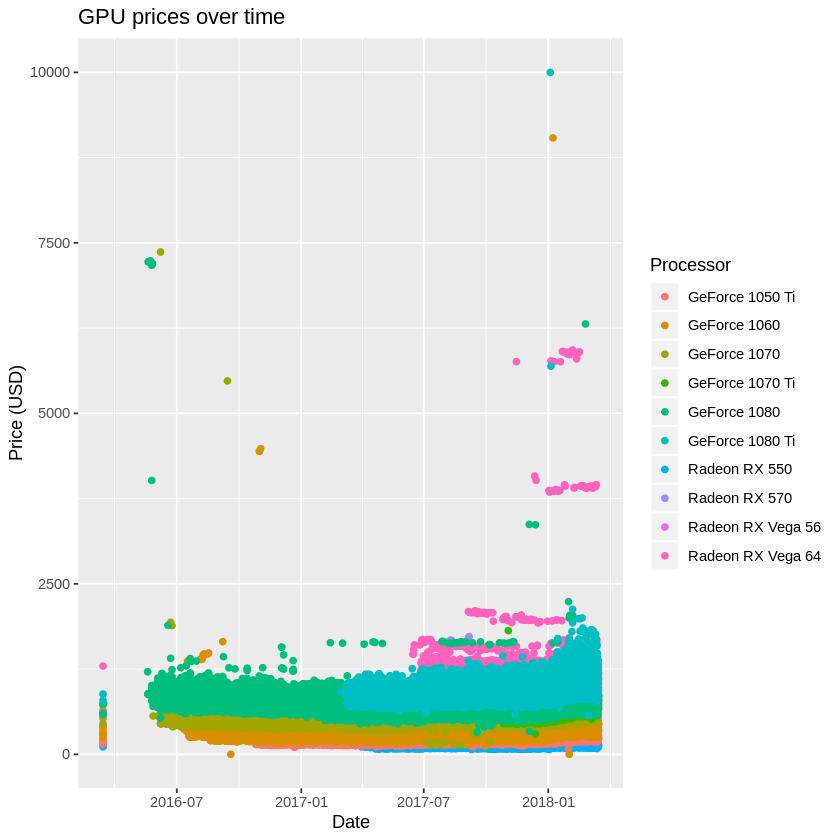

In [41]:
gpu_plot <- ggplot(data = our_gpus,
    aes(x = TimeId, y = Price_USD, colour = Processor)) +
    xlab("Date") + 
    ylab("Price (USD)") + 
    ggtitle("GPU prices over time") +
    geom_point()

gpu_plot

Look at those outliers! What on earth is the story here.  
We will save this as a csv named "techspot_gpu_prices.csv"

In [42]:
write_csv(gpu_prices, "techspot_gpu_prices.csv", col_names = TRUE)

# Checking the csv file for debugging
csv_check <- read_csv("techspot_gpu_prices.csv")
csv_check %>% 
    glimpse()
gpu_prices %>% 
    glimpse()

Parsed with column specification:
cols(
  gpu = col_character(),
  MSRP = col_double(),
  date = col_datetime(format = ""),
  price = col_double(),
  `price difference` = col_double(),
  brand = col_character()
)



Observations: 74
Variables: 6
$ gpu                <chr> "GeForce GTX 1050 Ti", "GeForce GTX 1060 3GB", "Ge…
$ MSRP               <dbl> 140, 200, 250, 380, 500, 700, 80, 170, 230, 140, 2…
$ date               <dttm> 2017-04-01, 2017-04-01, 2017-04-01, 2017-04-01, 2…
$ price              <dbl> 150, 220, 280, 420, 560, 755, 80, 190, 260, 160, 2…
$ `price difference` <dbl> 10, 20, 30, 40, 60, 55, 0, 20, 30, 20, 35, 60, 90,…
$ brand              <chr> "Nvidia", "Nvidia", "Nvidia", "Nvidia", "Nvidia", …
Observations: 74
Variables: 6
$ gpu                <chr> "GeForce GTX 1050 Ti", "GeForce GTX 1060 3GB", "Ge…
$ MSRP               <dbl> 140, 200, 250, 380, 500, 700, 80, 170, 230, 140, 2…
$ date               <dttm> 2017-04-01, 2017-04-01, 2017-04-01, 2017-04-01, 2…
$ price              <dbl> 150, 220, 280, 420, 560, 755, 80, 190, 260, 160, 2…
$ `price difference` <dbl> 10, 20, 30, 40, 60, 55, 0, 20, 30, 20, 35, 60, 90,…
$ brand              <chr> "Nvidia", "Nvidia", "Nvidia", "Nvidia", "Nvi

In [43]:
our_gpus %>% 
    top_n(20, Price_USD)

Id,Processor_Manufacturer,Processor,GPU_Manufacturer,Memory_Capacity,Memory_Type,TimeId,RegionId,MerchantId,Price_USD,Price_Original
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-01-22,10,68,5909.302,4238.24
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-01-23,10,68,5902.086,4222.50
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-01-24,10,68,5904.188,4156.46
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-02-01,10,68,5899.048,4141.22
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-02-06,10,68,5929.449,4250.14
937,AMD,Radeon RX Vega 64,AMD,16,HBM2,2018-02-16,10,68,5901.360,4199.26
1021,NVidia,GeForce 1060,Asus,6,GDDR5,2018-01-08,11,52,9039.000,9039.00
1047,NVidia,GeForce 1070,Asus,8,GDDR5,2016-06-07,1,71,7365.746,9999.00
1074,NVidia,GeForce 1080,Asus,8,GDDR5X,2016-05-20,1,71,7222.363,9999.00


Okay we're curious now, let's find out which merchants were price gouging. We can look up the store in the DIM_MERCHANT.csv by the MerchantID variable

In [44]:
stores <- read_csv("DIM_MERCHANT.csv")
stores %>% 
    glimpse()

Parsed with column specification:
cols(
  Id = col_double(),
  Merchant = col_character()
)



Observations: 81
Variables: 2
$ Id       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ Merchant <chr> "1stWave Technologies", "Adorama", "Alternate", "Alternate I…


In [45]:
stores %>% filter(Id == 52 | Id == 71 | Id == 68)

Id,Merchant
<dbl>,<chr>
52,Newegg Marketplace
68,pricespy_unknown
71,Scorptec


The two highest prices were on Newegg marketplace. Which makes sense, companies can just apply to trade there. Someone was being cheeky.  
Pricespy was one of the sites the data was scraped from, so I'd guess pricespy_unknown is a value where the merchant name failed to scrape. Which might explain why their prices are so absurd.  
Don't shop at Scorptec.

In [46]:
our_gpus %>% top_n(20, -Price_USD)

Id,Processor_Manufacturer,Processor,GPU_Manufacturer,Memory_Capacity,Memory_Type,TimeId,RegionId,MerchantId,Price_USD,Price_Original
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-04-26,3,50,80.8229999,109.99
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-09-10,10,68,71.2744263,54.00
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-10-05,10,8,80.3397373,61.20
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-10-08,10,68,75.2655856,57.60
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-10-09,10,68,80.4770765,61.20
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-10-14,11,47,73.9800000,73.98
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-11-08,11,47,78.9800000,78.98
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-11-17,11,47,76.3200000,76.32
884,AMD,Radeon RX 550,Gigabyte,2,GDDR5,2017-11-20,11,47,78.9800000,78.98


74 cents for a 1060! Nice

In [47]:
stores %>% 
    filter(Id == 29)

Id,Merchant
<dbl>,<chr>
29,DTC Systems


DTC Systems is a New Zealand company, so someone got a 1060 for 1 NZD (if this dataset is to be believed) 

## This doesn't work, delete

Ok that was a bit of fun. 
What we want now is a price differences over time plot. 
We'll need to join the gpu_prices df to get the MSRP column. But the Processor names don't match. 
Hopefully fuzzy_join will sort it out for us. 

https://www.rdocumentation.org/packages/fuzzyjoin/versions/0.1.5/topics/fuzzy_join

fuzz_grepper <- function(first, second) {
    
    for (pattern in gpu_names_for_grepl) {
        pattern = "1060"
        if (grepl(pattern, first)) { #&& grepl(pattern, second)) {
            return(TRUE)
        }
    }
    return(FALSE)
}

fuzzify <- function(df1, df2){
    return(which(with(df1, df2, fuzz_grepper(df1, df2))))
}

prayer <- stringdist_inner_join(our_gpus, gpu_prices, b = c("Processor" = "gpu"), distance_col = NULL)
#prayer

prayer_df <- fuzzy_join(our_gpus, gpu_prices, 
                        by = c("Processor" = "gpu"),
                       match_fun = fuzzify)
prayer_df 

## End delete

In [48]:
gpu_prices %>% filter(grepl(paste(unique(our_gpus$Processor), collapse="|"), gpu, ignore.case = TRUE))

gpu,MSRP,date,price,price difference,brand
<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
Radeon RX 550,80,2017-04-01,80,0,AMD
Radeon RX 570,170,2017-04-01,190,20,AMD
Radeon RX 550,80,2017-11-01,100,20,AMD
Radeon RX 570,170,2017-11-01,250,80,AMD
Radeon RX Vega 56,400,2017-11-01,450,50,AMD
Radeon RX Vega 64,500,2017-11-01,505,5,AMD
Radeon RX 550,80,2018-01-01,120,40,AMD
Radeon RX 570,170,2018-01-01,540,370,AMD
Radeon RX Vega 56,400,2018-01-01,670,270,AMD


In [49]:
get_reg <- function(Processor){
    # Function that takes a processor name and checks if it's one that in our dataframe, if so it returns the correct version of the name otherwise NA
    for (pattern in gpu_names_for_grepl) {
        if (grepl(pattern, Processor)) {
            return(pattern)
        }
    } 
    return(NA)
}

In [50]:
gpu_names_for_grepl

[1] "GeForce GTX 1050 Ti"  "GeForce GTX 1060 3GB" "GeForce GTX 1060 6GB"
 [4] "GeForce GTX 1070"     "GeForce GTX 1080"     "GeForce GTX 1080 Ti" 
 [7] "Radeon RX 550"        "Radeon RX 570"        "Radeon RX 580 8GB"   
[10] "GeForce GTX 1050 Ti"  "GeForce GTX 1060 3GB" "GeForce GTX 1060 6GB"
[13] "GeForce GTX 1070"     "GeForce GTX 1070 Ti"  "GeForce GTX 1080"    
[16] "GeForce GTX 1080 Ti"  "Radeon RX 550"        "Radeon RX 560 16CU"  
[19] "Radeon RX 570"        "Radeon RX 580 8GB"    "Radeon RX Vega 56"   
[22] "Radeon RX Vega 64"    "GeForce GTX 1050 Ti"  "GeForce GTX 1060 3GB"
[25] "GeForce GTX 1060 6GB" "GeForce GTX 1070"     "GeForce GTX 1070 Ti" 
[28] "GeForce GTX 1080"     "GeForce GTX 1080 Ti"  "Radeon RX 550"       
[31] "Radeon RX 560 16CU"   "Radeon RX 570"        "Radeon RX 580 8GB"   
[34] "Radeon RX Vega 56"    "Radeon RX Vega 64"    "GeForce GTX 1050 Ti" 
[37] "GeForce GTX 1060 3GB" "GeForce GTX 1060 6GB" "GeForce GTX 1070"    
[40] "GeForce GTX 1070 Ti"  "GeForce GTX 1080"     "GeForce GTX 1080 Ti" 
[43] "Radeon RX 560 16CU"   "Radeon RX 570"        "Radeon RX 580 8GB"   
[46] "Radeon RX Vega 56"    "Radeon RX Vega 64"    "GeForce GTX 1050 Ti" 
[49] "GeForce GTX 1060 3GB" "GeForce GTX 1060 6GB" "GeForce GTX 1070"    
[52] "GeForce GTX 1070 Ti"  "GeForce GTX 1080"     "GeForce GTX 1080 Ti" 
[55] "Radeon RX 560 16CU"   "Radeon RX 570"        "Radeon RX 580 8GB"   
[58] "Radeon RX Vega 56"    "Radeon RX Vega 64"    "GeForce GTX 1050 Ti" 
[61] "GeForce GTX 1060 3GB" "GeForce GTX 1060 6GB" "GeForce GTX 1070"    
[64] "GeForce GTX 1070 Ti"  "GeForce GTX 1080"     "GeForce GTX 1080 Ti" 
[67] "GeForce RTX 2070"     "GeForce RTX 2080"     "GeForce RTX 2080 Ti" 
[70] "Radeon RX 560 16CU"   "Radeon RX 570"        "Radeon RX 580 8GB"   
[73] "Radeon RX Vega 56"    "Radeon RX Vega 64"    "1050 Ti"             
[76] "1060"                 "1070 Ti"              "1070"                
[79] "1080 Ti"              "1080"

Ok, I'm well and truly stuck. Could use regex_join if we make a new column with grep-able strings.

In [51]:
our_gpus$regex_col <- our_gpus$Processor %>% 
    sapply(get_reg)
our_gpus

Id,Processor_Manufacturer,Processor,GPU_Manufacturer,Memory_Capacity,Memory_Type,TimeId,RegionId,MerchantId,Price_USD,Price_Original,regex_col
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
882,AMD,Radeon RX 550,Asus,2,GDDR5,2016-03-14,1,79,109.9151,145.00,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-20,1,33,157.4566,209.00,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-20,10,70,129.4641,100.96,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,1,67,134.9975,179.00,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,4,32,119.8031,112.08,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-21,10,68,117.6817,91.98,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,1,79,104.8621,139.00,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,4,32,112.7176,105.09,Radeon RX 550
882,AMD,Radeon RX 550,Asus,2,GDDR5,2017-04-22,10,68,119.0013,92.89,Radeon RX 550


Now we can use this great function, regex_join, which allows us to combine the two dataframes if an item from the column "regex_col" is greppable by the column "gpu"  

Source: https://www.rdocumentation.org/packages/fuzzyjoin/versions/0.1.5/topics/regex_join

In [52]:
joined_df <- select(gpu_prices, gpu, MSRP) %>% # we only need 2 columns from gpu_prices
    regex_join(our_gpus,                       # regex_join uses a column in one df to merge by a column in another df if regex matches
                        by = c(gpu = "regex_col"))   
joined_df %>% glimpse()

Observations: 1,993,061
Variables: 14
$ gpu                    <chr> "GeForce GTX 1050 Ti", "GeForce GTX 1050 Ti", …
$ MSRP                   <dbl> 140, 140, 140, 140, 140, 140, 140, 140, 140, 1…
$ Id                     <dbl> 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007…
$ Processor_Manufacturer <chr> "NVidia", "NVidia", "NVidia", "NVidia", "NVidi…
$ Processor              <chr> "GeForce 1050 Ti", "GeForce 1050 Ti", "GeForce…
$ GPU_Manufacturer       <chr> "Asus", "Asus", "Asus", "Asus", "Asus", "Asus"…
$ Memory_Capacity        <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dttm> 2016-10-24, 2016-10-25, 2016-10-25, 2016-10-2…
$ RegionId               <dbl> 4, 1, 3, 4, 10, 10, 1, 4, 10, 11, 1, 1, 1, 4, …
$ MerchantId             <dbl> 32, 67, 40, 32, 68, 70, 71, 32, 68, 47, 33, 71…
$ Price_USD              <dbl> 217.9597, 213.4023, 161.3010, 205.9903, 192.73…
$ Price_Origin

Now we have the MSRP matched to the right gpu. We may now change the dataframe to better suit our needs. We will make a new column "price_difference" which is Price_USD - MSRP.  
We will select only rows that are from the time period we are after, e.g later than march 2017. We will remove a few doubled up or useless columns.  

In [53]:
joined_df <- joined_df %>% 
    mutate(price_difference = Price_USD - MSRP)
joined_df %>% 
    head()

gpu,MSRP,Id,Processor_Manufacturer,Processor,GPU_Manufacturer,Memory_Capacity,Memory_Type,TimeId,RegionId,MerchantId,Price_USD,Price_Original,regex_col,price_difference
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-24,4,32,217.9597,200.3767,1050 Ti,77.95969
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-25,1,67,213.4023,279.0000,1050 Ti,73.40227
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-25,3,40,161.3010,214.9900,1050 Ti,21.30097
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-25,4,32,205.9903,189.1650,1050 Ti,65.99029
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-25,10,68,192.7317,158.0400,1050 Ti,52.73171
GeForce GTX 1050 Ti,140,1007,NVidia,GeForce 1050 Ti,Asus,4,GDDR5,2016-10-25,10,70,195.7195,160.4900,1050 Ti,55.71951


In [54]:
joined_df <- joined_df %>% 
  subset(TimeId > "2017-3-1") %>%    # Choose only rows with date older than march 2017
  mutate(price_difference = Price_USD - MSRP) %>%   # New variable, price difference
  select(-`Id`, -`gpu`, -`regex_col`)  # Remove unnecessary columns 

In [55]:
joined_df %>% glimpse()

Observations: 1,444,437
Variables: 12
$ MSRP                   <dbl> 140, 140, 140, 140, 140, 140, 140, 140, 140, 1…
$ Processor_Manufacturer <chr> "NVidia", "NVidia", "NVidia", "NVidia", "NVidi…
$ Processor              <chr> "GeForce 1050 Ti", "GeForce 1050 Ti", "GeForce…
$ GPU_Manufacturer       <chr> "Asus", "Asus", "Asus", "Asus", "Asus", "Asus"…
$ Memory_Capacity        <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dttm> 2017-03-02, 2017-03-02, 2017-03-02, 2017-03-0…
$ RegionId               <dbl> 3, 3, 4, 10, 10, 11, 1, 1, 3, 3, 3, 4, 9, 10, …
$ MerchantId             <dbl> 63, 80, 32, 30, 68, 47, 20, 67, 63, 74, 80, 32…
$ Price_USD              <dbl> 162.5243, 150.7622, 179.4501, 188.4879, 183.91…
$ Price_Original         <dbl> 217.4900, 201.7500, 170.6840, 153.6233, 149.90…
$ price_difference       <dbl> 22.52429, 10.76222, 39.45014, 48.48795, 43.919…


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Computation failed in `stat_smooth()`:
cannot allocate vector of size 110.2 Mb”


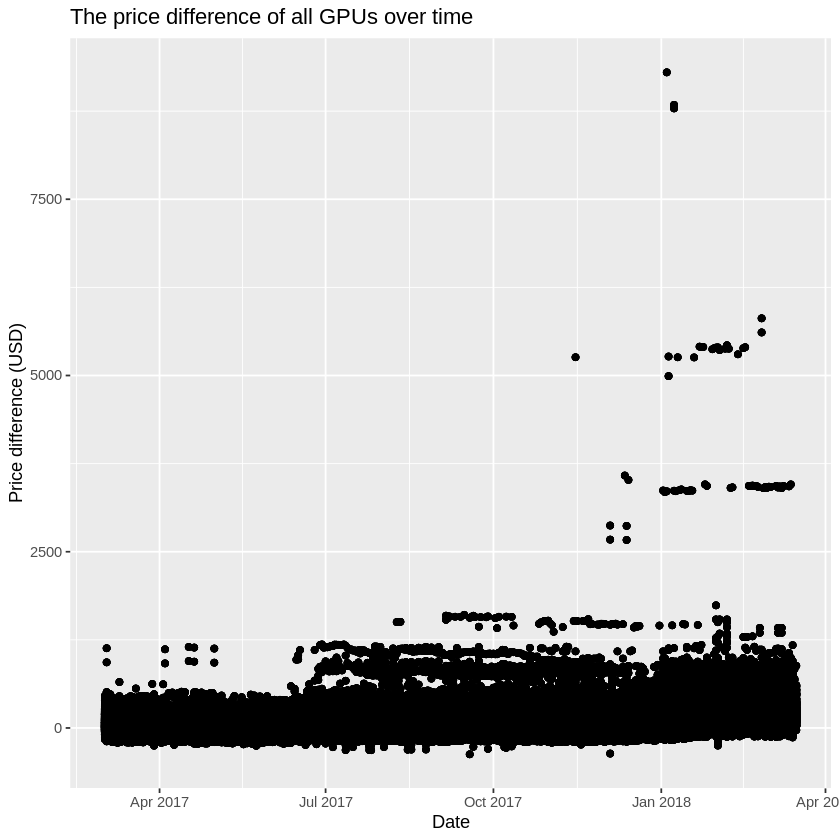

In [56]:
# Creating a graph for the price difference in GPUs over time
all_gpu_plot <- ggplot(joined_df, aes(x = TimeId, y = price_difference)) + 
    geom_point() + 
    geom_smooth() +
    ggtitle("The price difference of all GPUs over time") +
    xlab("Date") +
    ylab("Price difference (USD)")
all_gpu_plot

In [57]:
# Subset allows us to only select the rows with the value we want
ten_seventy_df <- joined_df %>% subset(Processor == "GeForce 1070")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



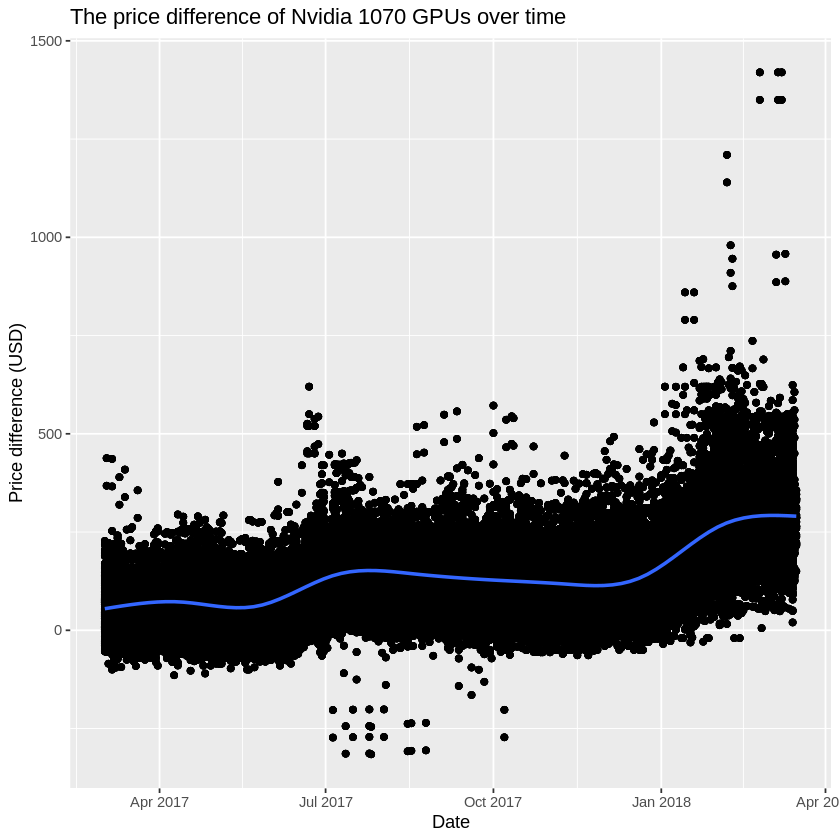

In [58]:
# Creating a graph for the price difference 1070 GPUs over time
ten_seventy_plot <- ggplot(ten_seventy_df, aes(x = TimeId, y = price_difference)) + 
    geom_point() + 
    geom_smooth() +
    ggtitle("The price difference of Nvidia 1070 GPUs over time") +
    xlab("Date") +
    ylab("Price difference (USD)")
ten_seventy_plot

In [59]:
ten_eighty_df <- joined_df %>% subset(Processor == "GeForce 1080")   # Choose only Geforce 1080 rows 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



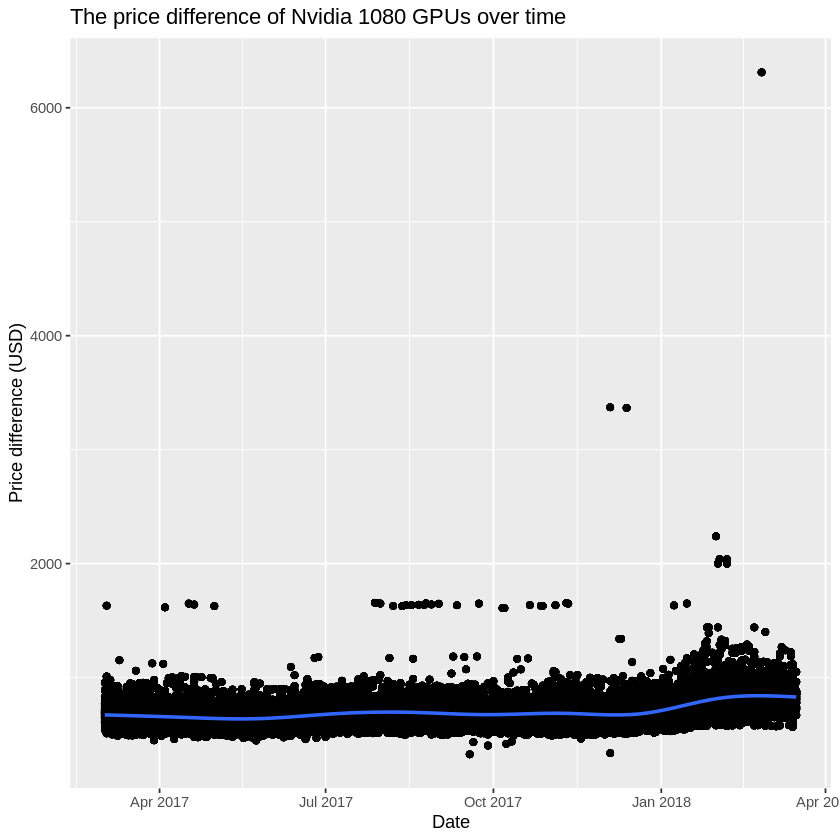

In [60]:
# Creating a graph for the price difference in 1080 GPUs over time
ten_eighty_plot <- ggplot(ten_eighty_df, aes(x = TimeId, y = Price_USD)) + 
    geom_point() + 
    geom_smooth() +
    ggtitle("The price difference of Nvidia 1080 GPUs over time") +
    xlab("Date") +
    ylab("Price difference (USD)")
ten_eighty_plot

In [61]:
# Save join_df to a csv file, with column names at the top
write_csv(joined_df, "GPU_PRICES_OUTPUT_PROJECT.csv", col_names = TRUE)

In [62]:
in_csv <- read_csv("GPU_PRICES_OUTPUT_PROJECT.csv")   # sanity check, read the csv we just made 

Parsed with column specification:
cols(
  MSRP = col_double(),
  Processor_Manufacturer = col_character(),
  Processor = col_character(),
  GPU_Manufacturer = col_character(),
  Memory_Capacity = col_double(),
  Memory_Type = col_character(),
  TimeId = col_datetime(format = ""),
  RegionId = col_double(),
  MerchantId = col_double(),
  Price_USD = col_double(),
  Price_Original = col_double(),
  price_difference = col_double()
)



In [63]:
in_csv %>% glimpse()
joined_df %>% glimpse()

Observations: 1,444,437
Variables: 12
$ MSRP                   <dbl> 140, 140, 140, 140, 140, 140, 140, 140, 140, 1…
$ Processor_Manufacturer <chr> "NVidia", "NVidia", "NVidia", "NVidia", "NVidi…
$ Processor              <chr> "GeForce 1050 Ti", "GeForce 1050 Ti", "GeForce…
$ GPU_Manufacturer       <chr> "Asus", "Asus", "Asus", "Asus", "Asus", "Asus"…
$ Memory_Capacity        <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ Memory_Type            <chr> "GDDR5", "GDDR5", "GDDR5", "GDDR5", "GDDR5", "…
$ TimeId                 <dttm> 2017-03-02, 2017-03-02, 2017-03-02, 2017-03-0…
$ RegionId               <dbl> 3, 3, 4, 10, 10, 11, 1, 1, 3, 3, 3, 4, 9, 10, …
$ MerchantId             <dbl> 63, 80, 32, 30, 68, 47, 20, 67, 63, 74, 80, 32…
$ Price_USD              <dbl> 162.5243, 150.7622, 179.4501, 188.4879, 183.91…
$ Price_Original         <dbl> 217.4900, 201.7500, 170.6840, 153.6233, 149.90…
$ price_difference       <dbl> 22.52429, 10.76222, 39.45014, 48.48795, 43.919…
Observations: 

In [64]:
joined_df <- joined_df %>% select(`Processor`,  `TimeId`, `Price_USD`)
joined_df %>% glimpse()

Observations: 1,444,437
Variables: 3
$ Processor <chr> "GeForce 1050 Ti", "GeForce 1050 Ti", "GeForce 1050 Ti", "G…
$ TimeId    <dttm> 2017-03-02, 2017-03-02, 2017-03-02, 2017-03-02, 2017-03-02…
$ Price_USD <dbl> 162.5243, 150.7622, 179.4501, 188.4879, 183.9196, 134.9800,…


In [65]:
joined_df %>% head()

Processor,TimeId,Price_USD
<chr>,<dttm>,<dbl>
GeForce 1050 Ti,2017-03-02,162.5243
GeForce 1050 Ti,2017-03-02,150.7622
GeForce 1050 Ti,2017-03-02,179.4501
GeForce 1050 Ti,2017-03-02,188.4879
GeForce 1050 Ti,2017-03-02,183.9196
GeForce 1050 Ti,2017-03-02,134.9800


In [66]:
spread_df <- joined_df %>% mutate(i = row_number()) %>% spread(key=Processor, value = Price_USD)

#https://stackoverflow.com/questions/45898614/how-to-spread-columns-with-duplicate-identifiers/45898919#45898919
#shouldn't have removed my id numbers so hastily heh
spread_df %>% head()

TimeId,i,GeForce 1050 Ti,GeForce 1060,GeForce 1070,GeForce 1070 Ti,GeForce 1080,GeForce 1080 Ti,Radeon RX 550,Radeon RX 570,Radeon RX Vega 56,Radeon RX Vega 64
<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-03-02,1,162.5243,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-03-02,2,150.7622,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-03-02,3,179.4501,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-03-02,4,188.4879,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-03-02,5,183.9196,NA,NA,NA,NA,NA,NA,NA,NA,NA
2017-03-02,6,134.9800,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [67]:
spread_df <- spread_df %>% aggregate(by = list(joined_df$TimeId),   # aggregate groups the data frame by date. We must pass in a list the same size as spread_df
                        FUN = mean,                    # apply the mean() function to every grouped day, for every column
                        na.rm=TRUE)  #remove na values
spread_df %>% head()
# source http://www.datasciencemadesimple.com/aggregate-function-in-r/

Group.1,TimeId,i,GeForce 1050 Ti,GeForce 1060,GeForce 1070,GeForce 1070 Ti,GeForce 1080,GeForce 1080 Ti,Radeon RX 550,Radeon RX 570,Radeon RX Vega 56,Radeon RX Vega 64
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-03-02,2017-09-15 11:43:02,677506.7,204.2244,322.0026,549.4711,636.2487,689.3599,949.3835,119.8543,308.0090,597.4177,957.3685
2017-03-03,2017-09-14 17:18:36,673962.1,193.2563,329.9653,548.4366,670.5204,706.2777,944.1128,111.6324,326.2139,613.7034,849.3558
2017-03-04,2017-09-15 21:58:58,674256.0,196.3407,319.4831,550.7354,645.8000,697.8513,940.1302,116.9125,350.3384,827.0827,1046.1994
2017-03-05,2017-09-14 18:08:23,678989.1,198.7077,321.2226,550.0637,682.0890,703.7988,916.6178,123.2253,296.3428,833.6766,1176.7736
2017-03-06,2017-09-15 04:13:57,675731.2,197.7262,322.9933,547.1221,697.0967,698.1559,919.8023,121.6358,319.8656,702.6215,1049.8669
2017-03-07,2017-09-15 17:34:38,679673.7,195.7775,322.9798,551.8342,681.4015,701.0307,918.9078,115.9971,332.4752,660.3782,1032.9187


In [68]:
spread_df <- spread_df %>% 
    select(-`i`, -`TimeId`) %>% # select all but i and TimeId
    rename(date = `Group.1`)    # rename the first column

In [69]:
spread_df <- spread_df %>% mutate(date = as_date(date))   # convert dttm to date

In [70]:
gpu_and_btc_df <- merge(spread_df, api_data1, by.x = "date", by.y = "date") # merge the dataframes
gpu_and_btc_df %>% glimpse()  # have a glimpse

Observations: 380
Variables: 18
$ date                <date> 2017-03-02, 2017-03-03, 2017-03-04, 2017-03-05, …
$ `GeForce 1050 Ti`   <dbl> 204.2244, 193.2563, 196.3407, 198.7077, 197.7262,…
$ `GeForce 1060`      <dbl> 322.0026, 329.9653, 319.4831, 321.2226, 322.9933,…
$ `GeForce 1070`      <dbl> 549.4711, 548.4366, 550.7354, 550.0637, 547.1221,…
$ `GeForce 1070 Ti`   <dbl> 636.2487, 670.5204, 645.8000, 682.0890, 697.0967,…
$ `GeForce 1080`      <dbl> 689.3599, 706.2777, 697.8513, 703.7988, 698.1559,…
$ `GeForce 1080 Ti`   <dbl> 949.3835, 944.1128, 940.1302, 916.6178, 919.8023,…
$ `Radeon RX 550`     <dbl> 119.8543, 111.6324, 116.9125, 123.2253, 121.6358,…
$ `Radeon RX 570`     <dbl> 308.0090, 326.2139, 350.3384, 296.3428, 319.8656,…
$ `Radeon RX Vega 56` <dbl> 597.4177, 613.7034, 827.0827, 833.6766, 702.6215,…
$ `Radeon RX Vega 64` <dbl> 957.3685, 849.3558, 1046.1994, 1176.7736, 1049.86…
$ timestamp           <chr> "2017-03-02T00:00:00.000Z", "2017-03-03T00:00:00.…
$ symbol            

In [72]:
write_csv(gpu_and_btc_df, "gpu_and_btc_df.csv", col_names = TRUE)  # write to csv

# sanity check
check_csv <- read_csv("gpu_and_btc_df.csv")  # read the csv we wrote

# compare with the df 
check_csv %>% glimpse()
gpu_and_btc_df %>% glimpse()

Parsed with column specification:
cols(
  date = col_date(format = ""),
  `GeForce 1050 Ti` = col_double(),
  `GeForce 1060` = col_double(),
  `GeForce 1070` = col_double(),
  `GeForce 1070 Ti` = col_double(),
  `GeForce 1080` = col_double(),
  `GeForce 1080 Ti` = col_double(),
  `Radeon RX 550` = col_double(),
  `Radeon RX 570` = col_double(),
  `Radeon RX Vega 56` = col_double(),
  `Radeon RX Vega 64` = col_double(),
  timestamp = col_datetime(format = ""),
  symbol = col_character(),
  open = col_double(),
  high = col_double(),
  low = col_double(),
  close = col_double(),
  daily_average = col_double()
)



Observations: 380
Variables: 18
$ date                <date> 2017-03-02, 2017-03-03, 2017-03-04, 2017-03-05, …
$ `GeForce 1050 Ti`   <dbl> 204.2244, 193.2563, 196.3407, 198.7077, 197.7262,…
$ `GeForce 1060`      <dbl> 322.0026, 329.9653, 319.4831, 321.2226, 322.9933,…
$ `GeForce 1070`      <dbl> 549.4711, 548.4366, 550.7354, 550.0637, 547.1221,…
$ `GeForce 1070 Ti`   <dbl> 636.2487, 670.5204, 645.8000, 682.0890, 697.0967,…
$ `GeForce 1080`      <dbl> 689.3599, 706.2777, 697.8513, 703.7988, 698.1559,…
$ `GeForce 1080 Ti`   <dbl> 949.3835, 944.1128, 940.1302, 916.6178, 919.8023,…
$ `Radeon RX 550`     <dbl> 119.8543, 111.6324, 116.9125, 123.2253, 121.6358,…
$ `Radeon RX 570`     <dbl> 308.0090, 326.2139, 350.3384, 296.3428, 319.8656,…
$ `Radeon RX Vega 56` <dbl> 597.4177, 613.7034, 827.0827, 833.6766, 702.6215,…
$ `Radeon RX Vega 64` <dbl> 957.3685, 849.3558, 1046.1994, 1176.7736, 1049.86…
$ timestamp           <dttm> 2017-03-02, 2017-03-03, 2017-03-04, 2017-03-05, …
$ symbol            

### Alt coins
These coins do not need GPUs as much or at all like Proof of Work coins (like Bitcoin) do, so it could be a good idea to explore their trends as well.  
Just be aware that you might end up sending too many requests at once to the site via the coin_scrape function, so if you get any errors, that might it be what caused them, so just wait and try again, don't run it all at once if that becomes an issue.

In [73]:
# Proof of stake coins
neo_df <- coin_scrape("neo")
dash_df <- coin_scrape("dash")
pivx_df <- coin_scrape("pivx")

In [74]:
# Delegated proof of stake coins
eos_df <- coin_scrape("eos")
tron_df <- coin_scrape("tron")
cardano_df <- coin_scrape("cardano")

In [75]:
# Other (not proof of work)
bat_df <- coin_scrape("basic-attention-token")
lumen_df <- coin_scrape("stellar")
ripple_df <- coin_scrape("ripple")

In [76]:
# View the dataframes for debugging
neo_df
dash_df
pivx_df
eos_df
tron_df
cardano_df
bat_df
lumen_df
ripple_df

Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NEO,2018-12-31,8.12,8.15,7.42,7.53,"104,180,796","489,717,925"
NEO,2018-12-30,7.97,8.28,7.86,8.12,"113,712,668","527,716,103"
NEO,2018-12-29,8.02,8.32,7.74,7.97,"119,973,813","518,036,133"
NEO,2018-12-28,6.98,8.09,6.86,7.98,"123,245,949","518,522,039"
NEO,2018-12-27,7.87,7.88,6.91,6.96,"100,876,756","452,675,268"
NEO,2018-12-26,7.70,8.09,7.37,7.88,"115,818,985","512,175,989"
NEO,2018-12-25,8.49,8.49,7.27,7.69,"128,604,042","500,167,827"
NEO,2018-12-24,7.69,9.10,7.69,8.49,"206,500,280","551,686,421"
NEO,2018-12-23,7.11,8.05,7.11,7.70,"172,563,267","500,180,160"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
DASH,2018-12-31,81.84,83.10,78.62,79.06,"108,299,749","674,947,452"
DASH,2018-12-30,80.22,83.95,79.68,81.79,"103,433,722","698,091,183"
DASH,2018-12-29,84.36,84.80,80.35,80.35,"107,080,371","685,592,694"
DASH,2018-12-28,76.26,84.93,75.37,83.82,"121,544,934","715,093,574"
DASH,2018-12-27,84.41,84.73,75.94,76.40,"135,210,655","651,681,733"
DASH,2018-12-26,84.00,87.39,81.56,84.55,"128,734,179","720,992,055"
DASH,2018-12-25,92.76,92.76,80.98,83.96,"128,516,889","715,788,368"
DASH,2018-12-24,90.28,104.09,90.28,92.44,"164,735,127","787,975,283"
DASH,2018-12-23,87.62,91.97,87.62,90.23,"131,821,218","768,904,932"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
PIVX,2018-12-31,1.020000,1.020000,0.854769,0.861243,"2,765,503","48,902,406"
PIVX,2018-12-30,0.811860,1.090000,0.803849,1.020000,"15,346,238","58,124,207"
PIVX,2018-12-29,0.732918,0.916079,0.728490,0.807914,"3,388,624","45,874,280"
PIVX,2018-12-28,0.679272,0.748677,0.665340,0.731794,"403,724","41,552,105"
PIVX,2018-12-27,0.749556,0.751693,0.676592,0.676592,"656,141","38,417,702"
PIVX,2018-12-26,0.769145,0.803592,0.731452,0.749808,"452,912","42,574,970"
PIVX,2018-12-25,0.902688,0.902688,0.740798,0.770996,"1,135,925","43,778,062"
PIVX,2018-12-24,0.889660,1.030000,0.837886,0.899138,"6,726,547","51,054,107"
PIVX,2018-12-23,0.627904,0.941870,0.626647,0.919331,"3,448,758","52,200,671"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
EOS,2018-12-31,2.68,2.68,2.53,2.57,"737,955,581","2,326,269,031"
EOS,2018-12-30,2.63,2.69,2.57,2.68,"678,199,674","2,430,234,521"
EOS,2018-12-29,2.66,2.78,2.61,2.63,"832,583,860","2,382,126,415"
EOS,2018-12-28,2.32,2.71,2.30,2.65,"912,368,604","2,397,824,243"
EOS,2018-12-27,2.60,2.62,2.31,2.32,"786,076,003","2,104,540,284"
EOS,2018-12-26,2.53,2.69,2.51,2.60,"919,041,942","2,358,484,613"
EOS,2018-12-25,2.77,2.77,2.44,2.52,"1,040,752,729","2,286,352,110"
EOS,2018-12-24,2.82,3.10,2.79,2.79,"1,205,992,715","2,527,803,643"
EOS,2018-12-23,2.63,2.98,2.62,2.82,"1,098,757,163","2,556,251,264"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
TRON,2018-12-31,0.019973,0.020001,0.018826,0.018826,"65,808,388","1,254,466,431"
TRON,2018-12-30,0.020046,0.020442,0.019709,0.019947,"71,517,430","1,329,143,863"
TRON,2018-12-29,0.020889,0.021028,0.020004,0.020004,"97,614,433","1,332,915,269"
TRON,2018-12-28,0.018512,0.021018,0.018147,0.020868,"125,947,733","1,390,471,113"
TRON,2018-12-27,0.020437,0.020527,0.018393,0.018488,"101,383,039","1,231,854,130"
TRON,2018-12-26,0.020011,0.020920,0.019593,0.020447,"126,978,263","1,362,422,619"
TRON,2018-12-25,0.021057,0.021057,0.018724,0.020008,"134,753,602","1,333,092,749"
TRON,2018-12-24,0.020908,0.023671,0.020689,0.021070,"189,212,251","1,403,852,883"
TRON,2018-12-23,0.021036,0.022000,0.020621,0.020911,"137,162,934","1,393,248,734"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CARDANO,2018-12-31,0.043232,0.043364,0.040493,0.041063,"19,280,457","1,064,641,798"
CARDANO,2018-12-30,0.041597,0.043665,0.040842,0.043280,"27,767,174","1,122,116,468"
CARDANO,2018-12-29,0.041873,0.043940,0.041210,0.041508,"30,992,034","1,076,193,322"
CARDANO,2018-12-28,0.037017,0.042634,0.036501,0.041862,"26,948,333","1,085,348,670"
CARDANO,2018-12-27,0.041225,0.041690,0.036548,0.036944,"22,969,395","957,851,765"
CARDANO,2018-12-26,0.041603,0.043035,0.039076,0.041198,"27,218,409","1,068,154,537"
CARDANO,2018-12-25,0.045675,0.045675,0.039243,0.041511,"38,493,644","1,076,264,960"
CARDANO,2018-12-24,0.044286,0.049282,0.044286,0.045716,"57,936,798","1,185,292,600"
CARDANO,2018-12-23,0.042203,0.044855,0.041819,0.044230,"40,656,190","1,146,761,807"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BASIC-ATTENTION-TOKEN,2018-12-31,0.138579,0.138579,0.127113,0.128429,"4,305,989","156,901,761"
BASIC-ATTENTION-TOKEN,2018-12-30,0.136094,0.139625,0.135087,0.138512,"3,972,638","169,219,891"
BASIC-ATTENTION-TOKEN,2018-12-29,0.139731,0.143814,0.135971,0.136130,"4,586,082","166,309,498"
BASIC-ATTENTION-TOKEN,2018-12-28,0.128578,0.140594,0.128151,0.139647,"7,488,539","170,606,127"
BASIC-ATTENTION-TOKEN,2018-12-27,0.142110,0.142110,0.128171,0.128489,"5,330,379","156,974,362"
BASIC-ATTENTION-TOKEN,2018-12-26,0.139404,0.144744,0.137975,0.141714,"4,420,649","173,088,979"
BASIC-ATTENTION-TOKEN,2018-12-25,0.150814,0.150814,0.132971,0.139177,"4,481,958","169,990,908"
BASIC-ATTENTION-TOKEN,2018-12-24,0.148721,0.157387,0.148310,0.150679,"8,222,204","183,511,285"
BASIC-ATTENTION-TOKEN,2018-12-23,0.149100,0.154657,0.147168,0.148753,"5,126,892","181,165,989"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
STELLAR,2018-12-31,0.117709,0.117888,0.112506,0.112813,"101,118,303","2,161,590,359"
STELLAR,2018-12-30,0.118284,0.119345,0.116329,0.117430,"87,412,670","2,250,048,215"
STELLAR,2018-12-29,0.121677,0.122356,0.118036,0.118036,"99,849,382","2,261,665,627"
STELLAR,2018-12-28,0.110513,0.122760,0.109658,0.121383,"122,279,839","2,325,792,456"
STELLAR,2018-12-27,0.120487,0.120645,0.110157,0.110486,"84,397,745","2,116,993,848"
STELLAR,2018-12-26,0.121735,0.125530,0.117893,0.120607,"105,367,076","2,310,919,892"
STELLAR,2018-12-25,0.133123,0.133342,0.119143,0.121682,"111,648,903","2,331,526,162"
STELLAR,2018-12-24,0.126668,0.141351,0.126668,0.132520,"169,588,599","2,539,102,176"
STELLAR,2018-12-23,0.123208,0.128494,0.122604,0.126585,"128,331,036","2,425,398,421"


Crytocurrencies,Date,Open*,High,Low,Close**,Volume,Market Cap
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
RIPPLE,2018-12-31,0.371051,0.373793,0.350787,0.352706,"501,793,515","14,388,351,240"
RIPPLE,2018-12-30,0.365248,0.371147,0.362264,0.369581,"486,955,034","15,076,740,856"
RIPPLE,2018-12-29,0.378346,0.383937,0.367080,0.367252,"617,892,297","14,981,716,068"
RIPPLE,2018-12-28,0.341807,0.379416,0.339139,0.376852,"765,420,103","15,373,342,678"
RIPPLE,2018-12-27,0.379106,0.379608,0.336282,0.341162,"575,821,047","13,917,404,309"
RIPPLE,2018-12-26,0.379991,0.391334,0.363441,0.378693,"690,588,635","15,448,432,552"
RIPPLE,2018-12-25,0.408439,0.408439,0.369362,0.380872,"955,306,080","15,537,325,695"
RIPPLE,2018-12-24,0.372398,0.448477,0.372398,0.406799,"1,688,430,313","16,594,994,618"
RIPPLE,2018-12-23,0.363045,0.381476,0.361807,0.371270,"634,162,707","15,145,652,798"


In [77]:
get_coin_price_chart <- function(coin_df, name)
{
    #function that creates a plot of a coins price history by taking a dataframe of its pricing data and it's name
    # Create dataframe for historical bitcoin prices and plot data from dataframe
    coin_plot <- coin_df %>%
        # x axis set to date, y axis set to price
        ggplot(aes(x = Date, y = High, group = 1)) + 
        # geom set to line
        geom_line() +
        # label graphs axis and title it
        labs(title = paste("Price of", name, "(USD) over time", sep = " "), x = "Date", y = "Price (USD)") 

    return(coin_plot)
}

#### Proof of Stake coins
The following graphs are of Proof of Stake (PoS) coins, proof of stake currencies instead of a user's influence over the coin being based on computing power, it's based on how much of the coin that user owns.  
So where before coins could theoretically be taken over by pools or individuals with over 50% of the computing power behind the coin by faking transactions Proof of Stake creates a direct incentive to not try and hijack the coin where if you do that when you own over 50% of the coin you will lose money as the coins value will detoriate if you try to control it by illegimate means. Making the money you have invested worth less.

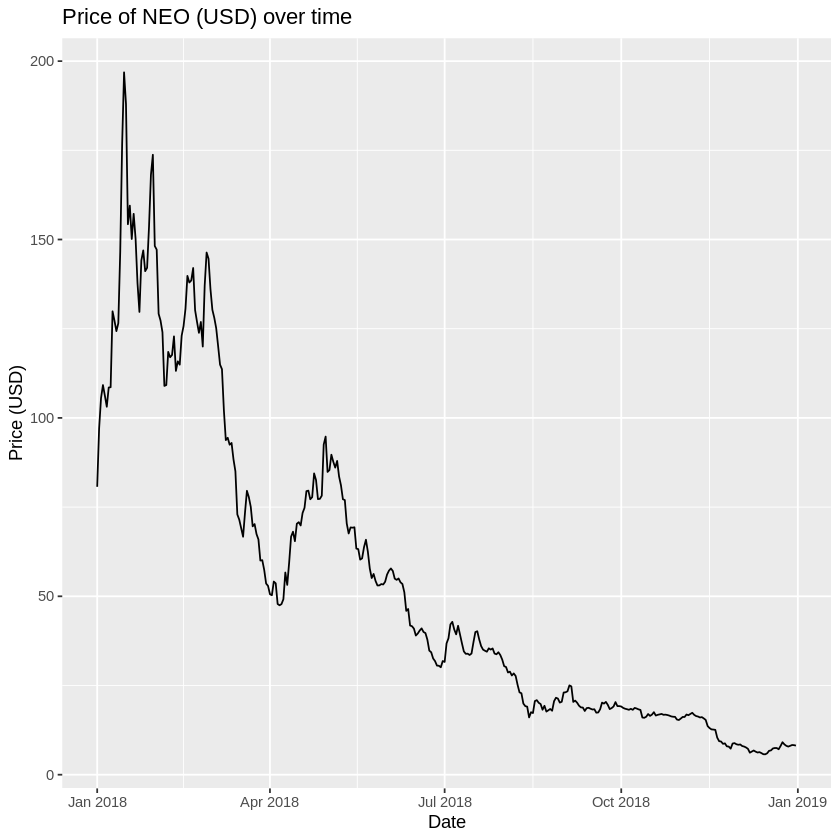

In [78]:
get_coin_price_chart(neo_df, "NEO")

The above coin is NEO, a proof of stake coin created in 2014 and running stably since october 2016. (https://neo.org/)

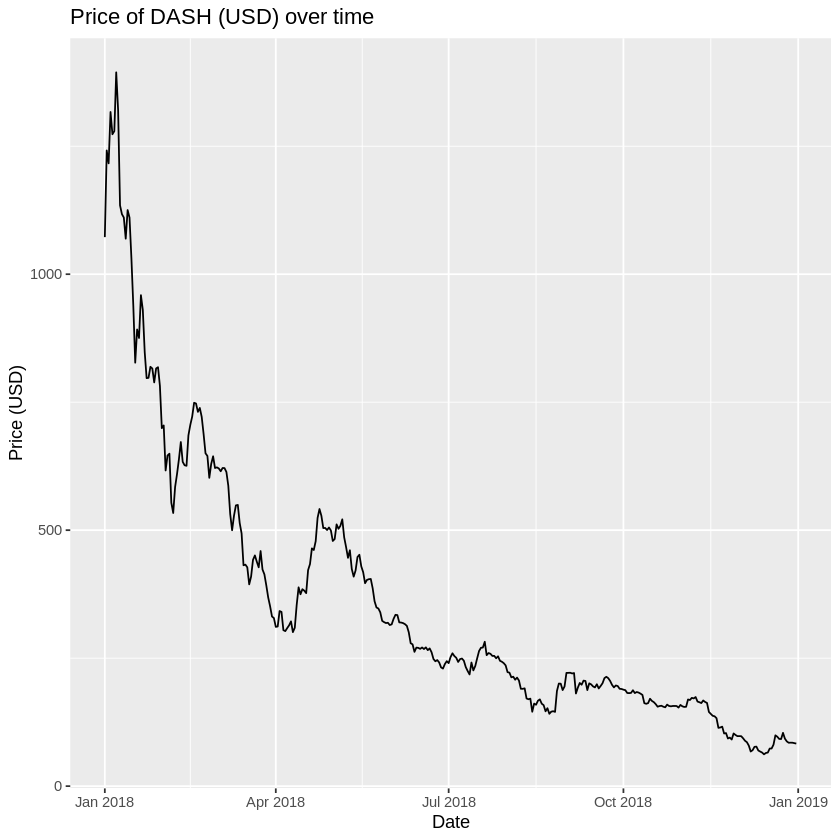

In [79]:
get_coin_price_chart(dash_df, "DASH")

The above coin is DASH, a proof of stake coin created in 2015. (https://www.dash.org/)

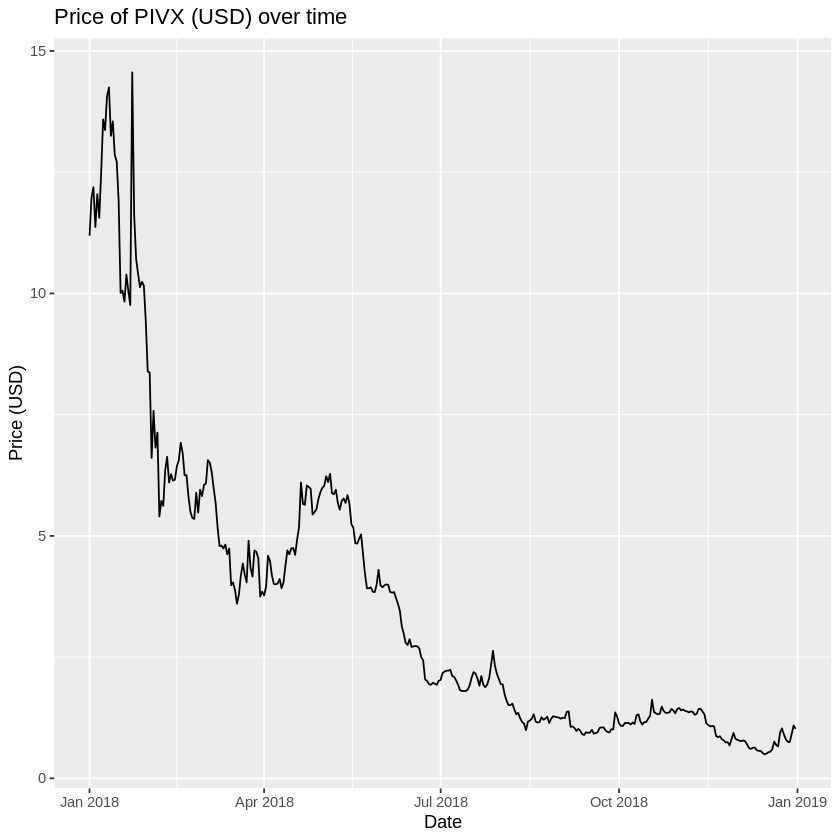

In [80]:
get_coin_price_chart(pivx_df, "PIVX")

The above coin is PIVX, a proof of stake coin created in 2016. (https://www.pivx.org)

#### Delegated Proof of Stake coins

The following coins are Delegated proof of stake (dPoS) which is similar to PoS but involves voting from community members for representatives who validate the transactions instead of everyone voting on the validation and the weight of their vote being determined by the size of their stake. The weight is still determined by the size of their stake, but a smaller but trusted party is voted to validate representatively instead on the validation for the next block, making the PoS process more efficient.

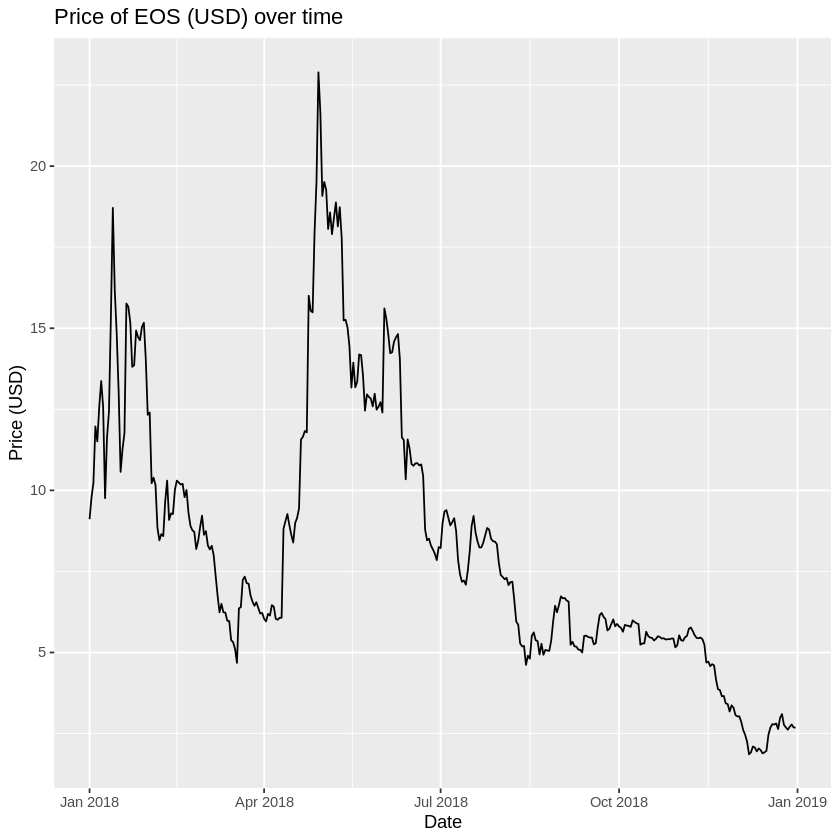

In [81]:
get_coin_price_chart(eos_df, "EOS")

The above coin is EOS, a delegated proof of stake coin created in 2018. (https://eos.io/)

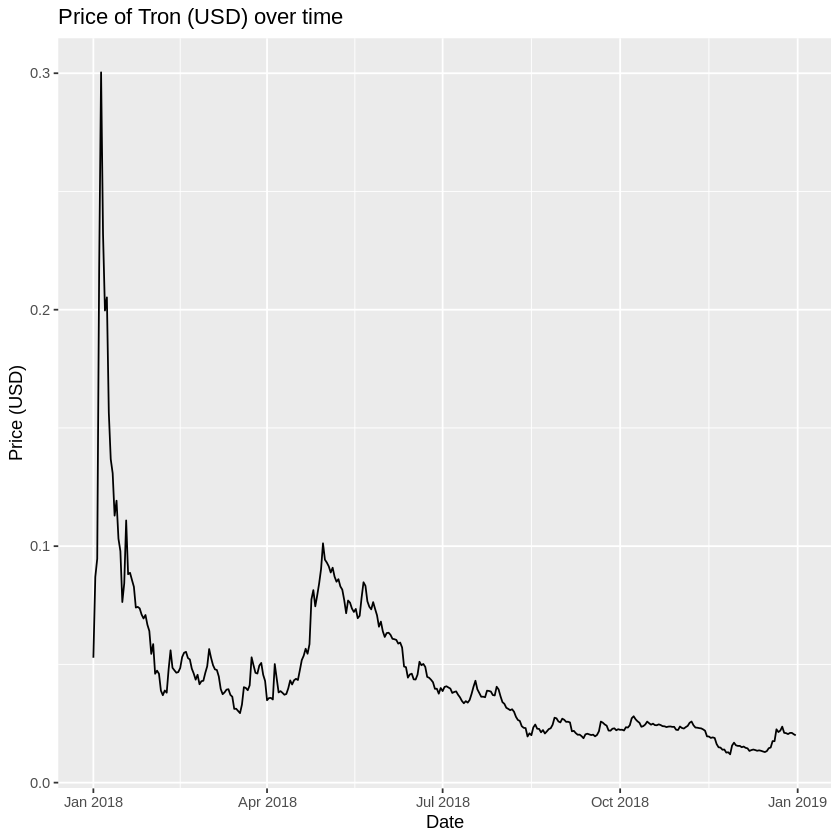

In [82]:
get_coin_price_chart(tron_df, "Tron")

The above coin is Tron, a delegated proof of stake coin created in 2017. (https://tron.network/)

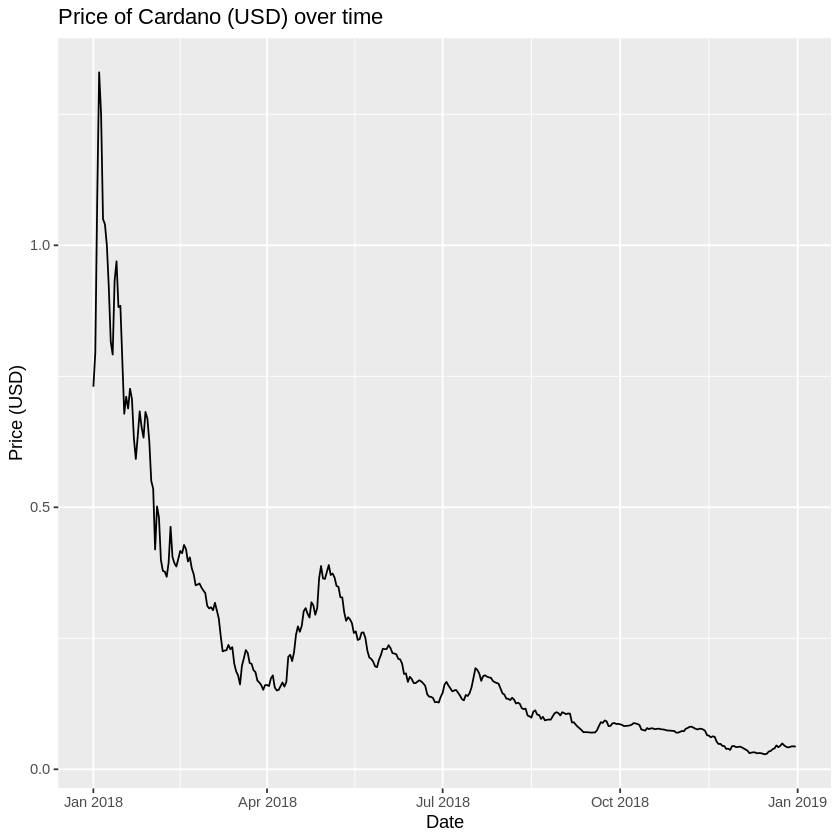

In [83]:
get_coin_price_chart(cardano_df, "Cardano")

The above coin is Cardano, a delegated proof of stake coin created in 2013. (https://www.cardano.org/en/home/)

#### Other coins (Not Proof of Work)
The next 3 coins don't follow PoW, Pos or dPoS. Instead they have their own form of authentication, usually a trusted party like the owners of the coin. They're all unique and interesting.

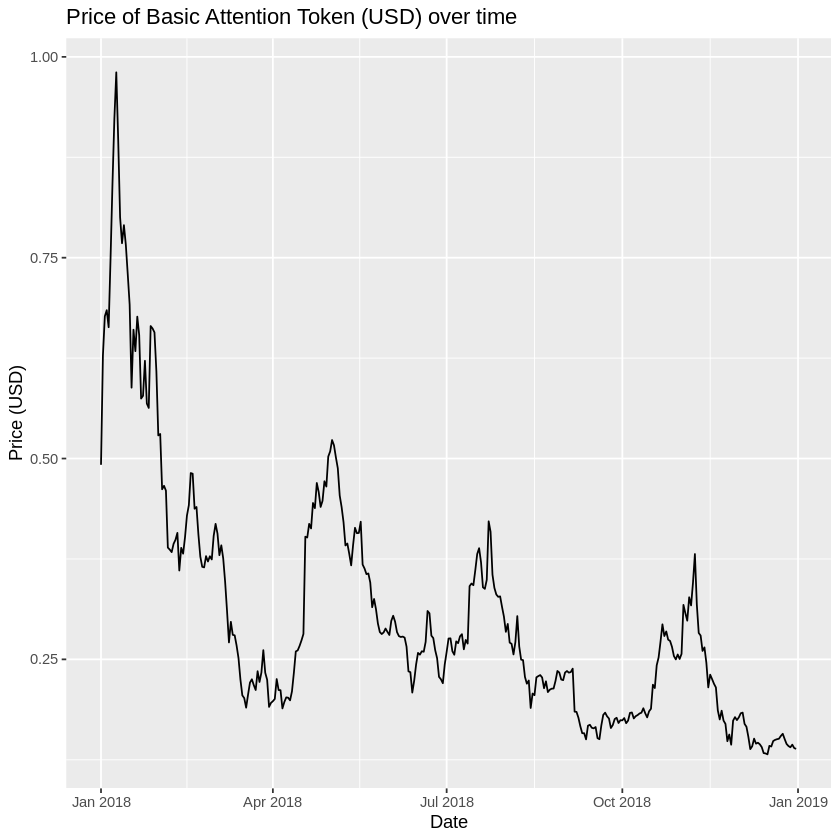

In [84]:
get_coin_price_chart(bat_df, "Basic Attention Token")

The above coin is Basic Attention Token, a crypto coin created in 2017 using the Ethereum platform and paired mainly with the Brave browser intended to be used as an alternative to traditional advertising revenue for online content creators. (https://basicattentiontoken.org/)

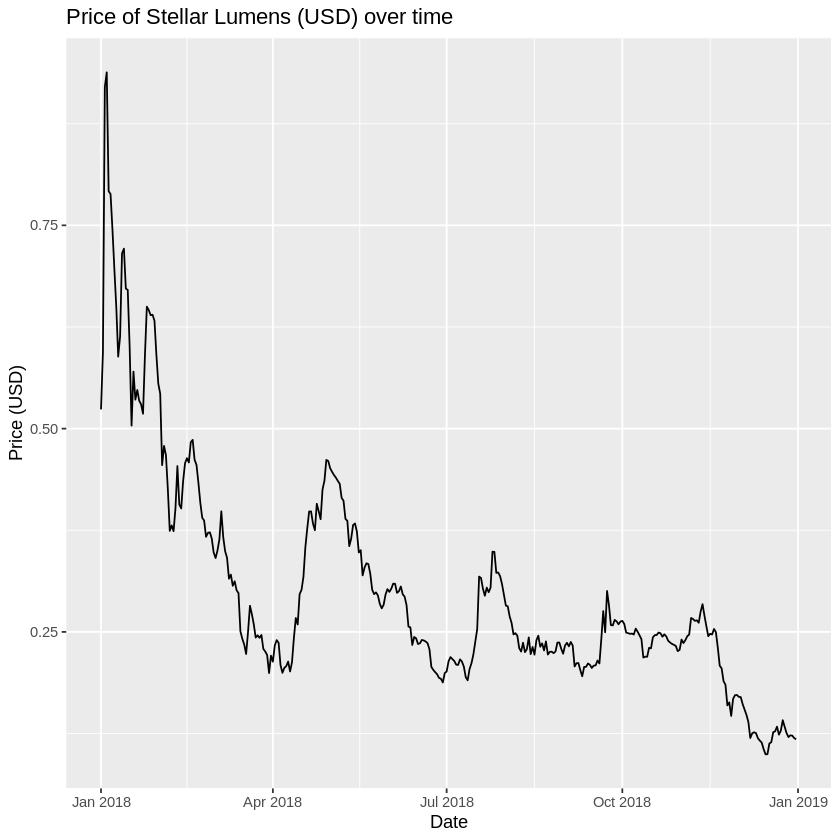

In [85]:
get_coin_price_chart(lumen_df, "Stellar Lumens")

The above coin is Stellar Lumens a coin created in 2017 which you might be familar as the coin that keybase has been giving away. (https://www.stellar.org/lumens/)

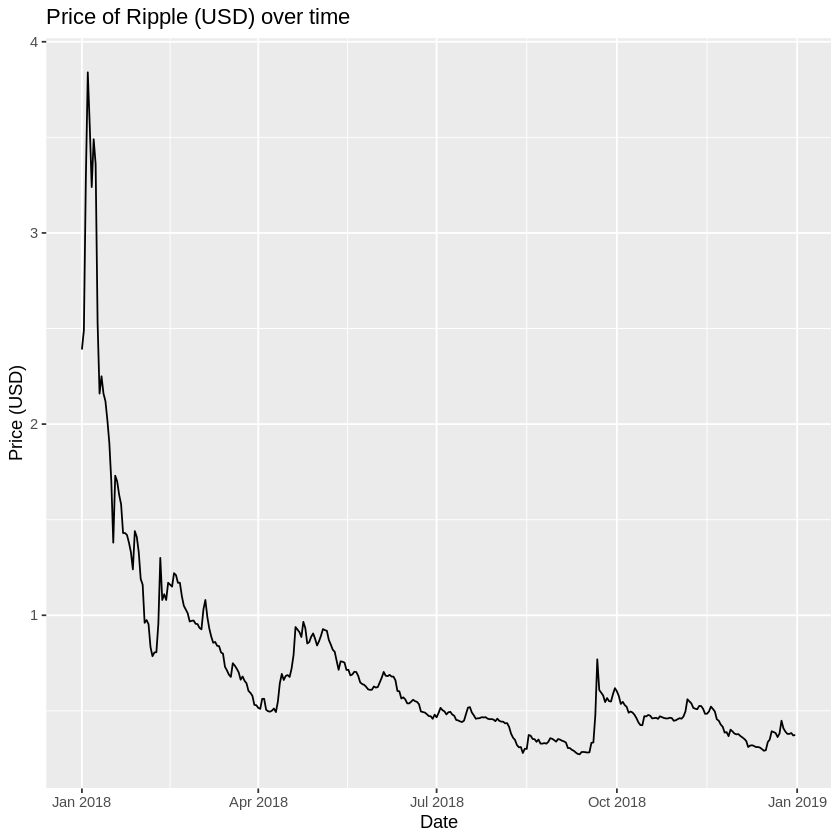

In [86]:
get_coin_price_chart(ripple_df, "Ripple")

The above coin is Ripple a coin created in 2012 created and recently converted to a unique authentication method. (https://www.ripple.com/xrp/)